## ENCM 509 Final Project (Face Detection and Recognition using OpenCV)
## Group 7
## Members: Ahmed Anwar, Ali Mekawy, Mohamed Mahmoud

In [3]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
import numpy as np
from sklearn.utils import shuffle
import os
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import shutil
from sklearn.metrics import roc_curve, det_curve
from glob import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

## Visualizing the dataset

Found 40 classes: ['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']


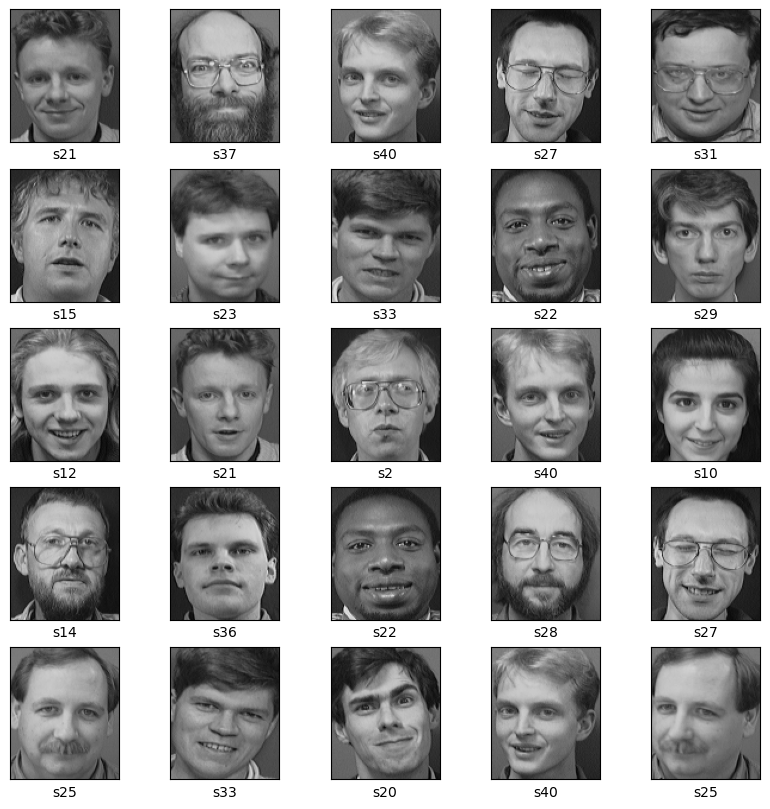

In [4]:
DATASET_PATH = 'ATT_dataset'

if not os.path.exists(DATASET_PATH):
    print('Dataset not found!')
    exit(1)

# Load dataset
classes = os.listdir(DATASET_PATH)
print('Found {} classes: {}'.format(len(classes), classes))

# Visualizing the images
images = []
labels = []
class_index = 0
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        images.append(image)
        labels.append(class_index)
    class_index += 1
images = np.array(images)
labels = np.array(labels)

# Shuffle the dataset with scikit-learn
images, labels = shuffle(images, labels, random_state=0)

# Plot 25 random images from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(classes[labels[i]])


# Splitting into training and testing datasets

In [9]:
TRAINING_SPLIT = 0.7

# Define source directory and target directories
src_dir = 'ATT_dataset'
train_dir = 'train_dataset'
test_dir = 'test_dataset'

# Create target directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of all subdirectories
subdirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

# Loop over each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(src_dir, subdir)
    images = os.listdir(subdir_path)
    
    # Shuffle the list of images
    np.random.shuffle(images)
    
    # Split the list of images into training and testing sets
    train_images = images[:int(TRAINING_SPLIT*len(images))]
    test_images = images[int(TRAINING_SPLIT*len(images)):]

    # Create corresponding subdirectories in the target directories
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)
    
    # Copy the training images to the training directory
    for image in train_images:
        shutil.copy(os.path.join(subdir_path, image), os.path.join(train_dir, subdir, image))
    
    # Copy the testing images to the testing directory
    for image in test_images:
        shutil.copy(os.path.join(subdir_path, image), os.path.join(test_dir, subdir, image))

## Face detection visualization

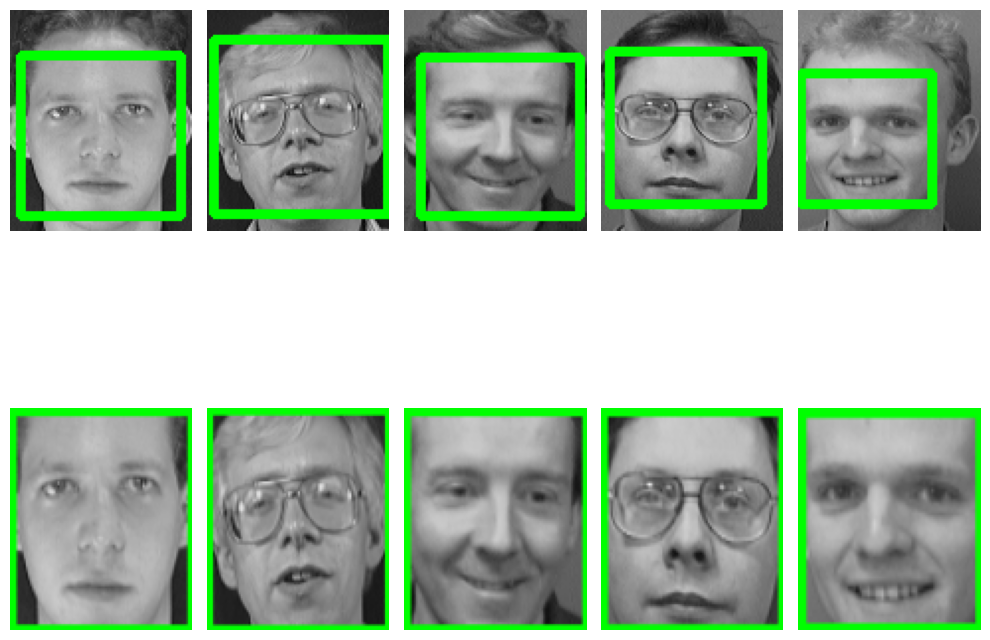

In [8]:
# Perform face detection on a few different subjects

# Load the images
images = []
cropped_faces = []
for i in range(1, 6):
    path = 'ATT_dataset/s{}/1.pgm'.format(i)
    img = cv2.imread(path)
    images.append(img)

# Perform face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for i in range(5):
    gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    face_box = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    for (x, y, w, h) in face_box:
        cv2.rectangle(images[i], (x, y), (x+w, y+h), (0, 255, 0), 3)
        cropped_faces.append(images[i][y:y+h, x:x+w])
        cropped_faces[-1] = cv2.resize(cropped_faces[-1], (92, 112))

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    
    plt.imshow(cropped_faces[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()


## LBP feature extraction visualization

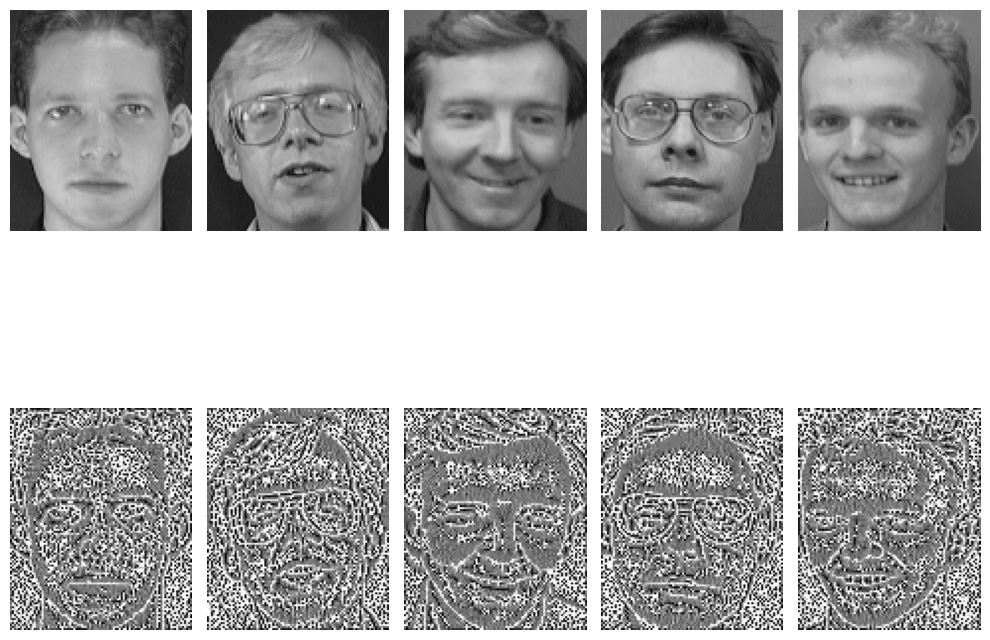

In [9]:
# Load the images
images = []
for i in range(1, 6):
    path = 'ATT_dataset/s{}/1.pgm'.format(i)
    img = cv2.imread(path)
    images.append(img)
    
# Perform LBP feature extraction
lbp_images = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 12, 1, 'uniform')
    lbp_images.append(lbp)

# Display the images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(lbp_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()





## Images loading and preprocessing

In [14]:
def get_data(path):
    
    paths = glob(path, recursive=True)
    data = []
    label = []

    for path in paths:
        img = cv2.imread(path, 0)
        subject_label = path[path.rfind('s')+1:path.rfind('\\')]

        img = cv2.resize(img, (1, len(img)* len(img[0])))
        img = np.float32(np.array(img) / 255.0)

        data.append(img)
        label.append(int(subject_label))

    return np.array(data)[:,:,0], np.array(label)

## TEST CODE IN BOX BELOW!

In [13]:
## test code
from skimage import img_as_ubyte

def get_data(path):
    
    paths = glob(path, recursive=True)
    data = []
    label = []

    for path in paths:
        img = cv2.imread(path, 0)
        subject_label = path[path.rfind('s')+1:path.rfind('\\')]

        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        
        face_box = face_cascade.detectMultiScale(img, scaleFactor=1.0001, minNeighbors=9)

        for (x, y, w, h) in face_box:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        face = img[y:y+h, x:x+w]


        # resize to original size
        face = cv2.resize(face, (92, 112))

        face = cv2.resize(face, (1, len(face)* len(face[0])))
        face = np.float32(np.array(face) / 255.0)

        # do lbp featyre excraction
        # lbp = local_binary_pattern(img, 12, 3)
        # (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2))
        

        # visualise image
        # plt.imshow(img, cmap='gray')

        # img = img_as_ubyte(img)

        # lbp = local_binary_pattern(img, 12, 3, method='default')
        # (hist, _) = np.histogram(lbp.ravel(), density= 'True', bins=np.arange(0, 8 + 3), range=(0, 8 + 2))

        # Normalize the images


        data.append(face)
        label.append(int(subject_label))

    return np.array(data)[:,:,0], np.array(label)

## SVM C = 0.1, gamma = 0.001, kernel = linear

In [15]:
train_path = r'train_dataset\\**\\*.pgm'
test_path = r'test_dataset\\**\\*.pgm'

train_data, train_label = get_data(train_path)
test_data, test_label = get_data(test_path)

svm = SVC(C= 0.1, gamma = 0.001, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_1 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_1 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))


SVM accuracy: 82.50%


## SVM C = 0.2, gamma = 0.001, kernel = linear

In [12]:
svm = SVC(C= 0.2, gamma = 0.001, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_2 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_2 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 82.50%


## SVM C = 0.05, gamma = 0.001, kernel = linear

In [142]:
svm = SVC(C= 0.05, gamma = 0.001, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_3 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_3 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 81.67%


## SVM C = 0.01, gamma = 0.001, kernel = linear

In [141]:
svm = SVC(C= 0.01, gamma = 0.001, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_4 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_4 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 77.50%


## SVM C = 0.1, gamma = 0.2, kernel = linear

In [140]:
svm = SVC(C= 0.1, gamma = 0.2, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_5 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_5 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 82.50%


## SVM C = 0.1, gamma = 0.01, kernel = linear

In [139]:
svm = SVC(C= 0.1, gamma = 0.01, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_6 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_6 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 82.50%


## SVM C = 0.1, gamma = 0.0001, kernel = linear

In [138]:
svm = SVC(C= 0.1, gamma = 0.0001, kernel='linear' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_7 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_7 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 82.50%


## SVM C = 0.1, gamma = 0.001, kernel = linear

In [137]:
svm = SVC(C= 0.1, gamma = 0.001, kernel='poly' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_8 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_8 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))

SVM accuracy: 64.17%


## SVM C = 0.1, gamma = 0.001, kernel = rbf

In [136]:
svm = SVC(C= 0.1, gamma = 0.001, kernel='rbf' , probability=True)
svm.fit(train_data, train_label)

# probability matrix NxM where N is number of samples and M is the number of classes
probability_matrix_svm_9 = svm.predict_proba(test_data)

# Make prediction
prediction_svm_9 = svm.predict(test_data)

# Calculate accuracy
accuracy_svm = svm.score(test_data, test_label)
print('SVM accuracy: {:.2f}%'.format(accuracy_svm * 100))


SVM accuracy: 68.33%


In [114]:
def generate_roc_det_curve(prob_mat):
    roc_fpr = np.zeros((40, 100))
    roc_tpr = np.zeros((40, 100))

    det_fpr = np.zeros((40, 100))
    det_fnr = np.zeros((40, 100))

    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

    for i in range(1,40):
        fpr, tpr, _ = roc_curve(test_label == i, prob_mat[:, i])

        roc_fpr[i] = np.linspace(min(fpr), max(fpr), 100)
        roc_tpr[i] = np.interp(roc_fpr[i], fpr, tpr)

        fpr, fnr, _ = det_curve(test_label[:] == i, prob_mat[:, i])
        det_fpr[i] = np.linspace(min(fpr), max(fpr), 100)
        det_fnr[i] = np.interp(det_fpr[i], fpr, fnr)

    roc_mid_fpr = np.mean(roc_fpr, axis=0)
    roc_mid_tpr = np.mean(roc_tpr, axis=0)
    ax_roc.plot(roc_mid_fpr, roc_mid_tpr, label='ROC curve')

    det_mid_fpr = np.mean(det_fpr, axis=0)
    det_mid_fnr = np.mean(det_fnr, axis=0)
    ax_det.plot(det_mid_fpr, det_mid_fnr, label='DET curve')

    # draw a dotted line through the origin
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_det.plot([0, 1], [1, 0], 'k--')

    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curve')

    ax_det.set_xlabel('False Positive Rate')
    ax_det.set_ylabel('False Negative Rate')
    ax_det.set_title('DET Curve')



# Looking at the different ROC and DET curves

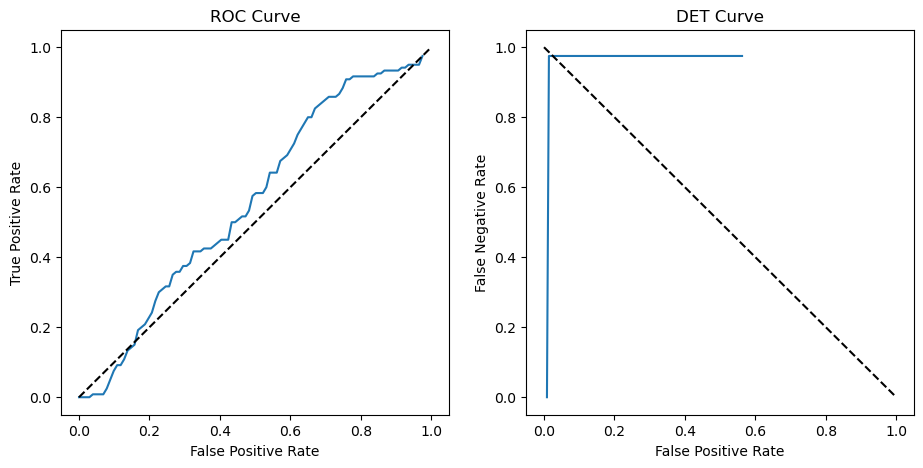

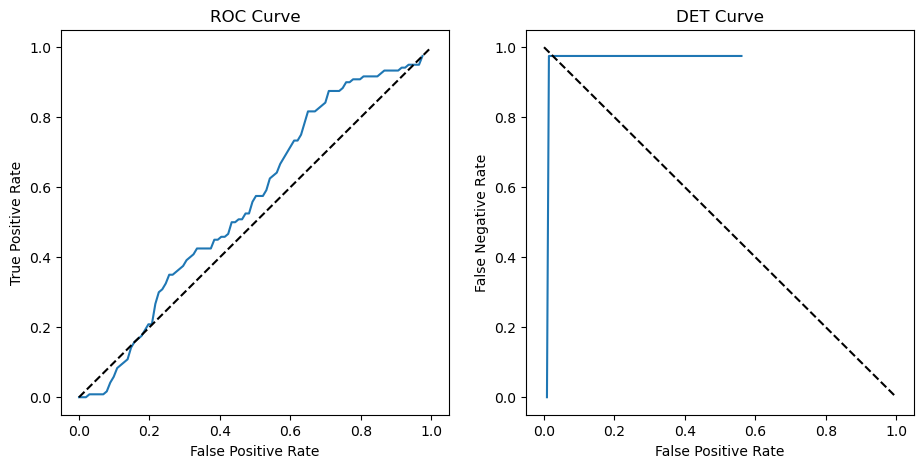

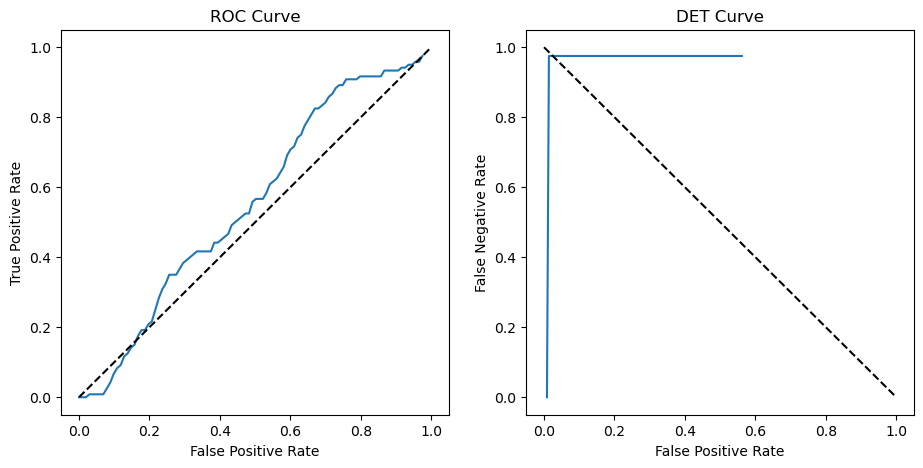

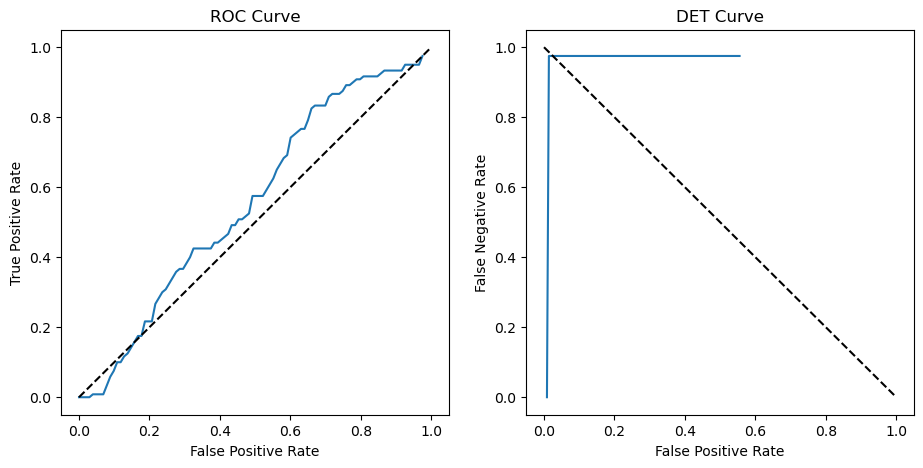

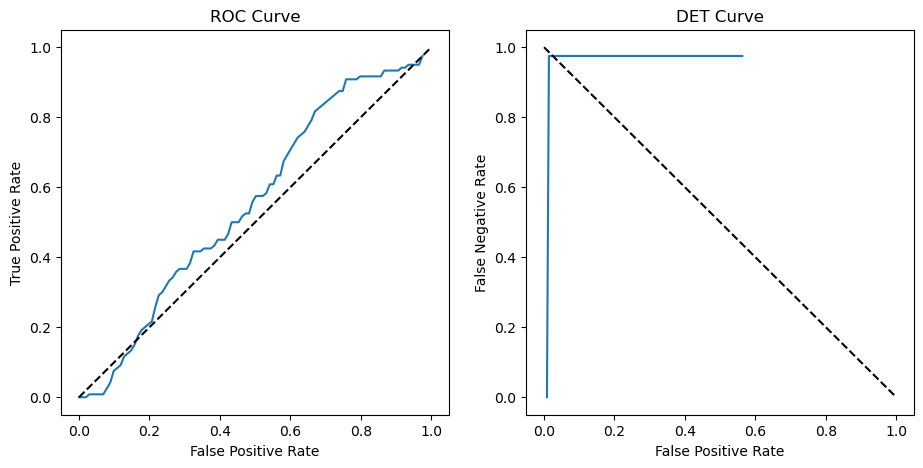

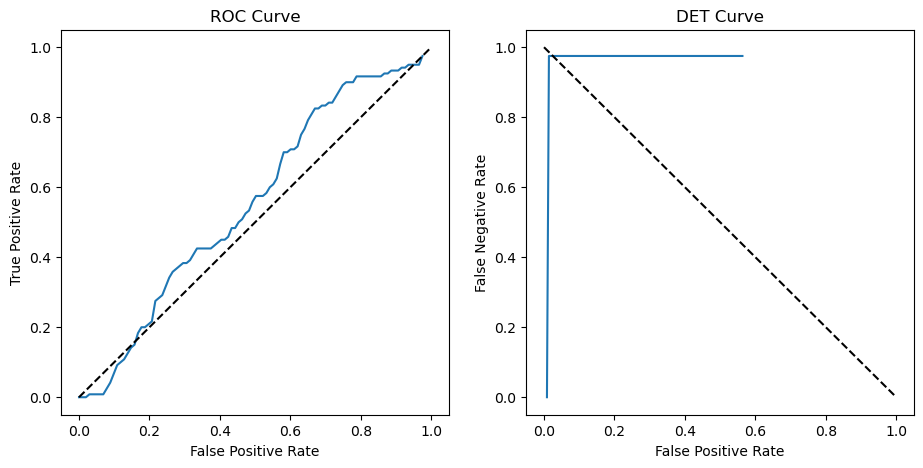

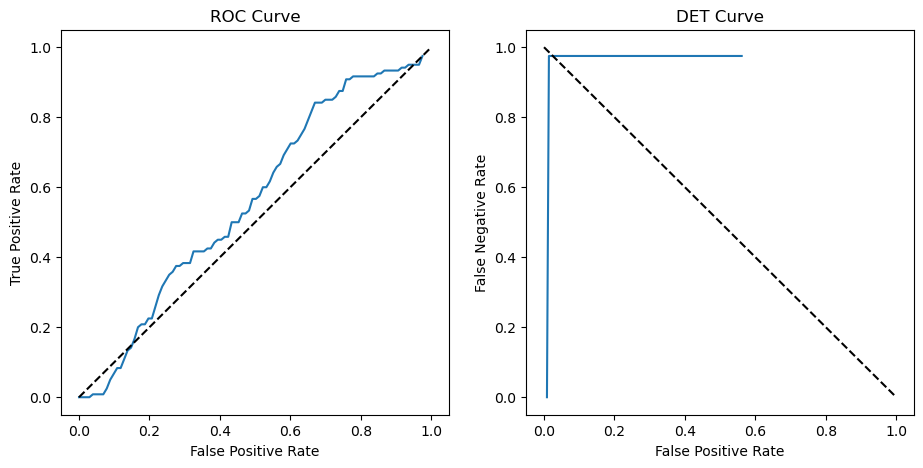

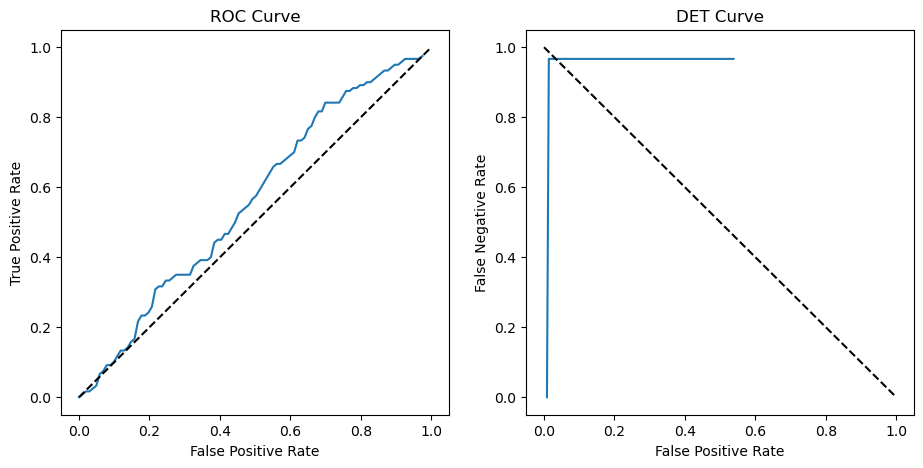

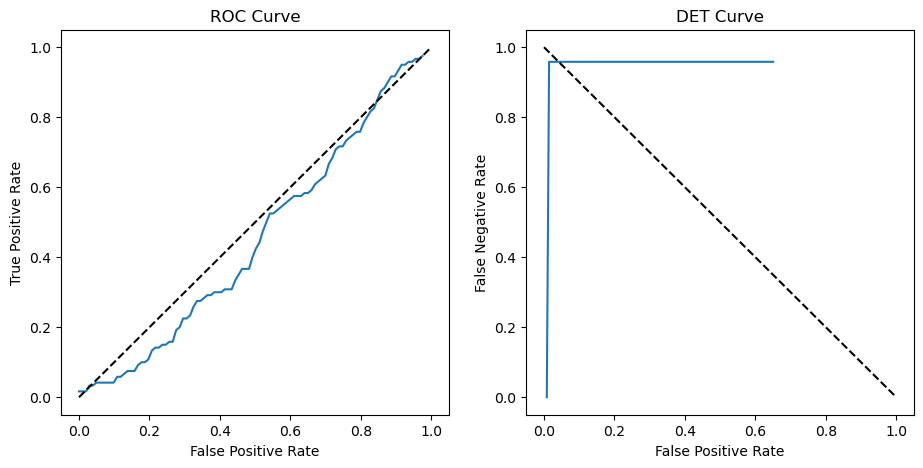

In [115]:
generate_roc_det_curve(probability_matrix_svm_1)
generate_roc_det_curve(probability_matrix_svm_2)
generate_roc_det_curve(probability_matrix_svm_3)
generate_roc_det_curve(probability_matrix_svm_4)
generate_roc_det_curve(probability_matrix_svm_5)
generate_roc_det_curve(probability_matrix_svm_6)
generate_roc_det_curve(probability_matrix_svm_7)
generate_roc_det_curve(probability_matrix_svm_8)
generate_roc_det_curve(probability_matrix_svm_9)

# Confustion matrix

In [148]:
# confusion matrix
def generate_confusion_matrix(pred):
    conf_matrix = confusion_matrix(test_label, pred)
    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)
    conf_matrix = np.round(conf_matrix, 2)
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(0, 40)],
                    columns = [i for i in range(0, 40)])
    plt.figure(figsize = (20,20))
    sns.heatmap(df_cm, annot=True)
    plt.show()


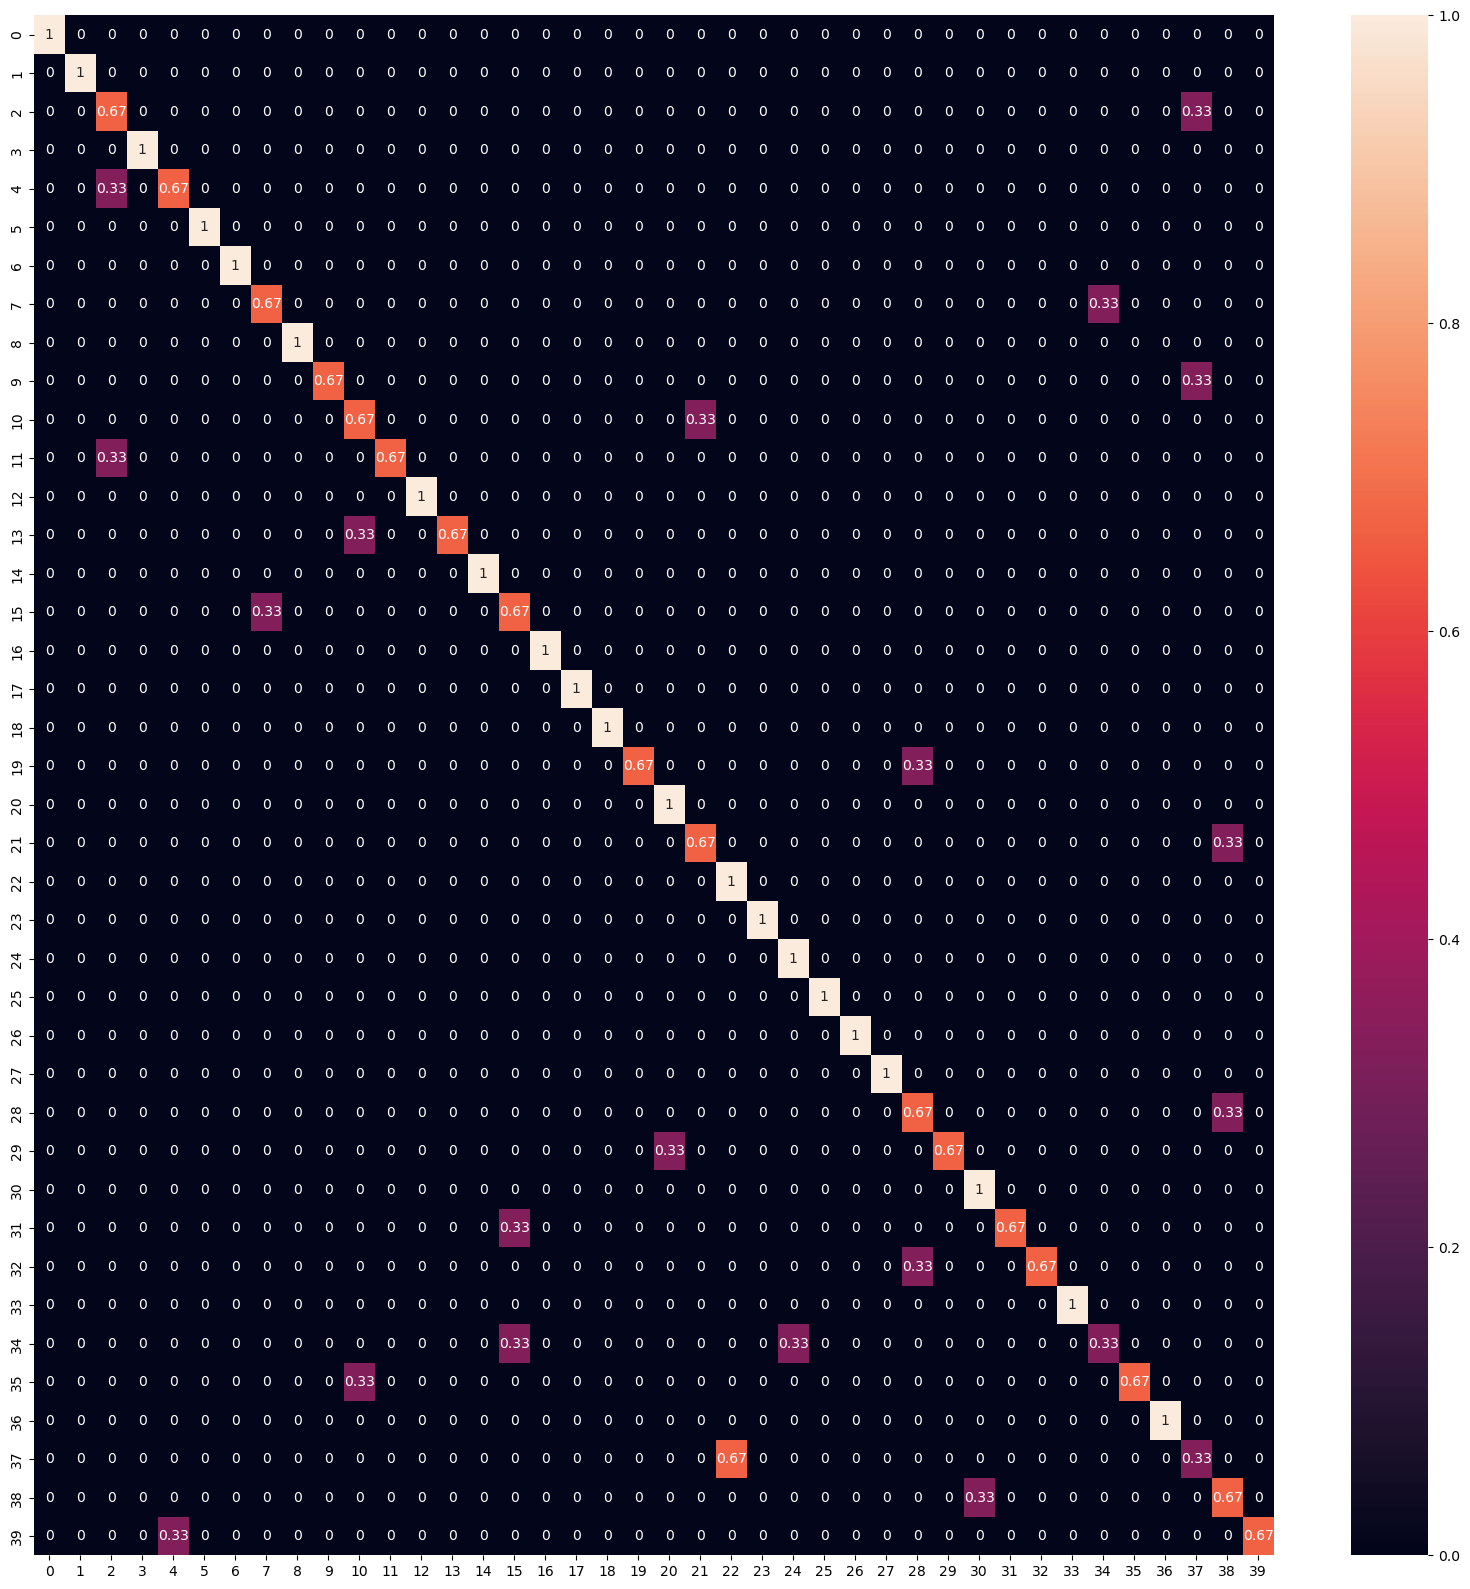

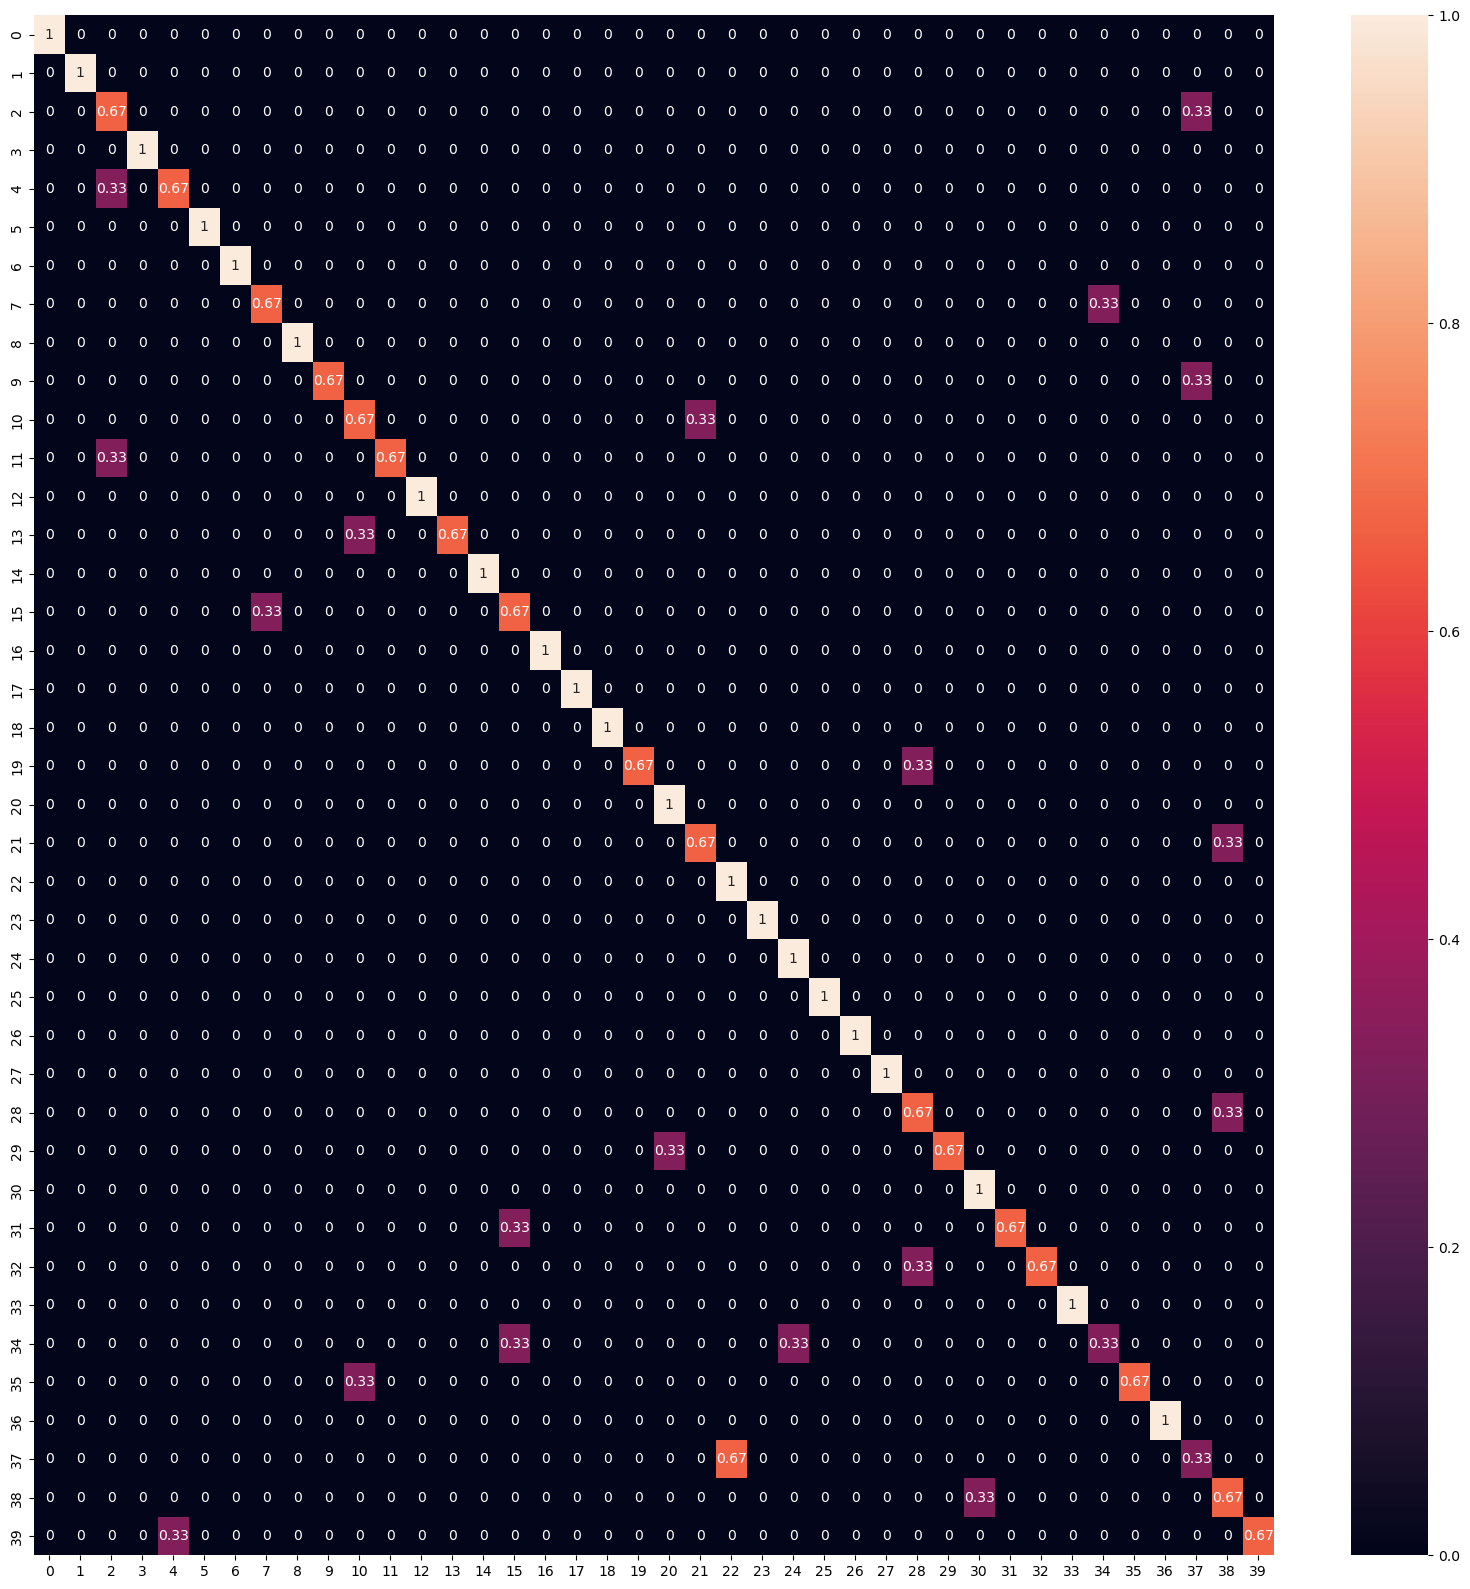

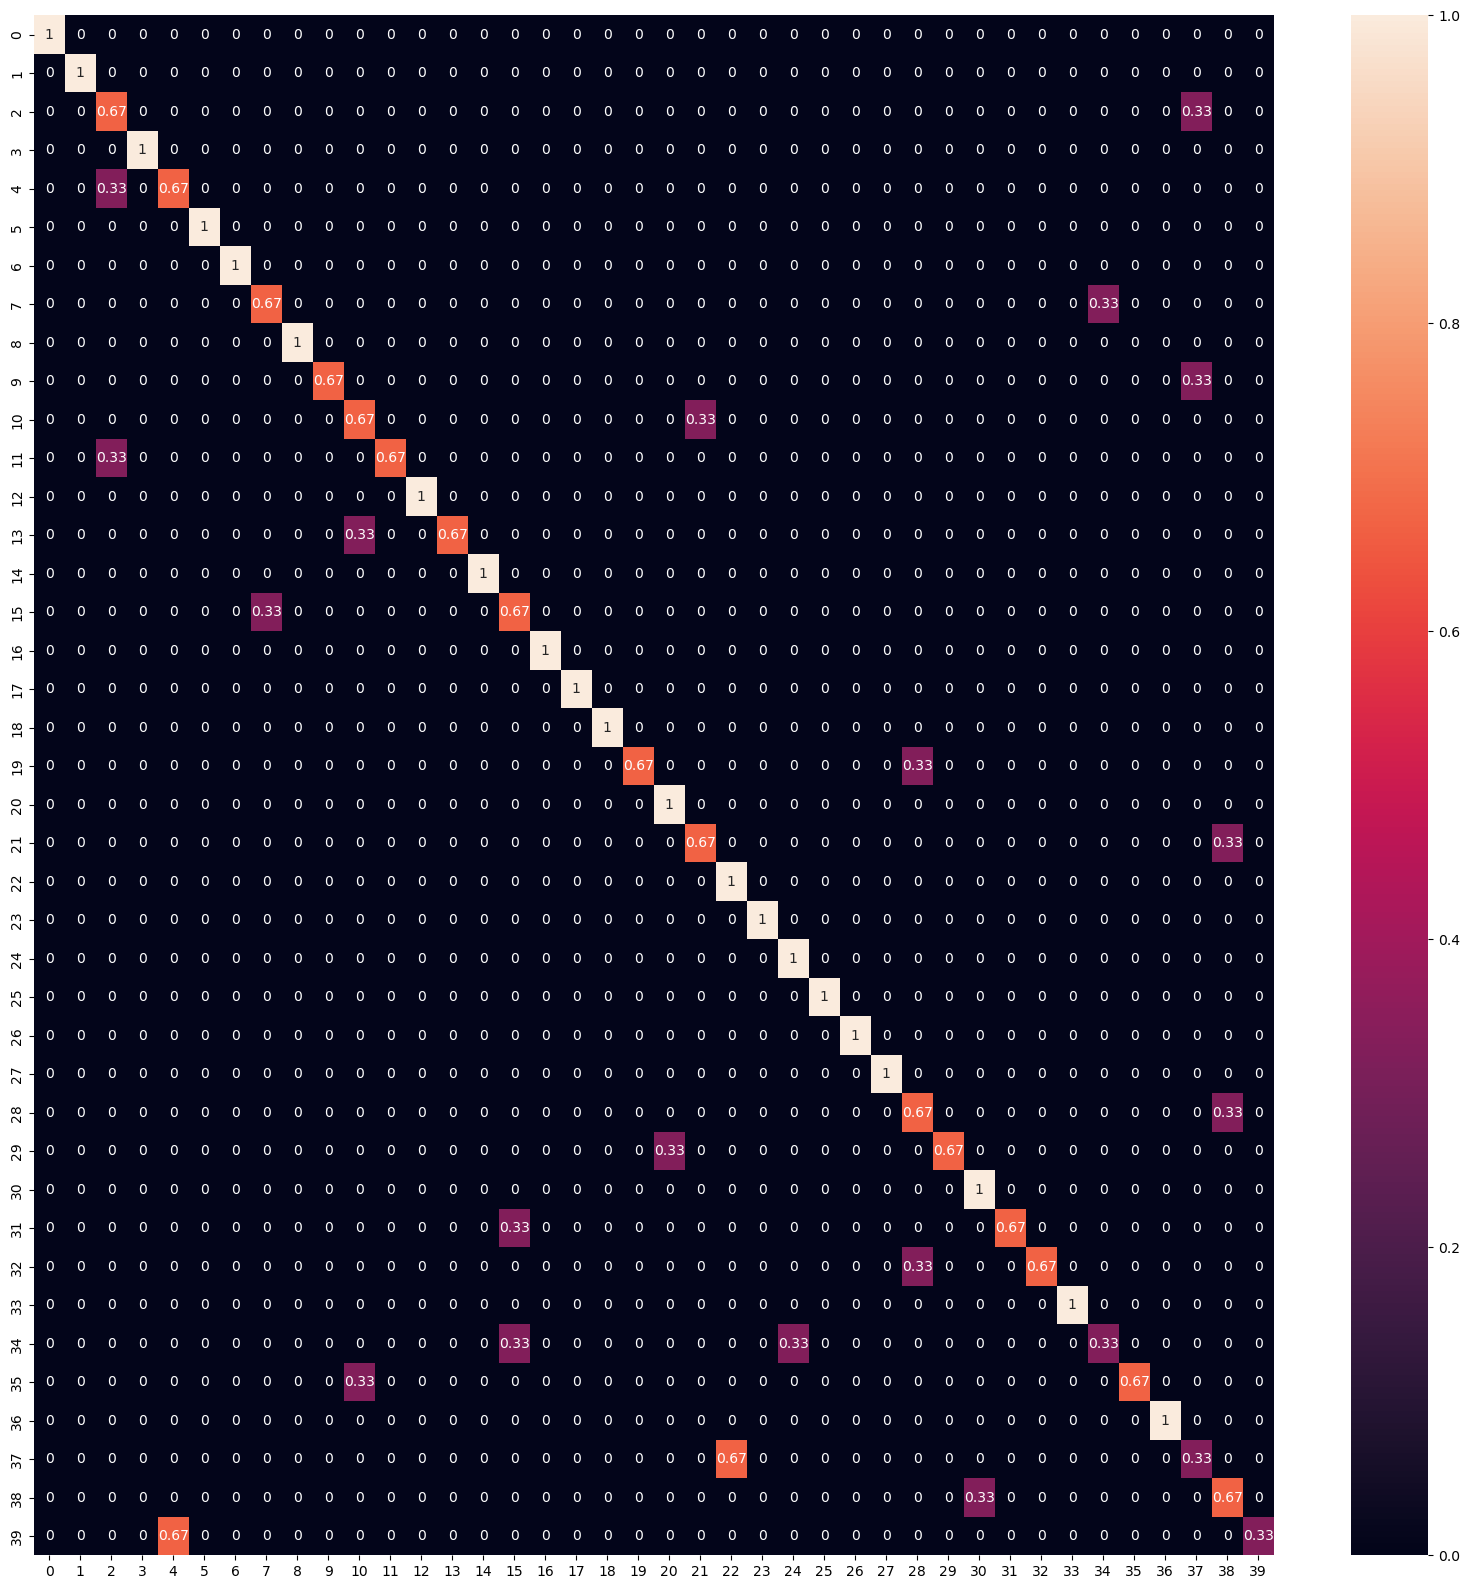

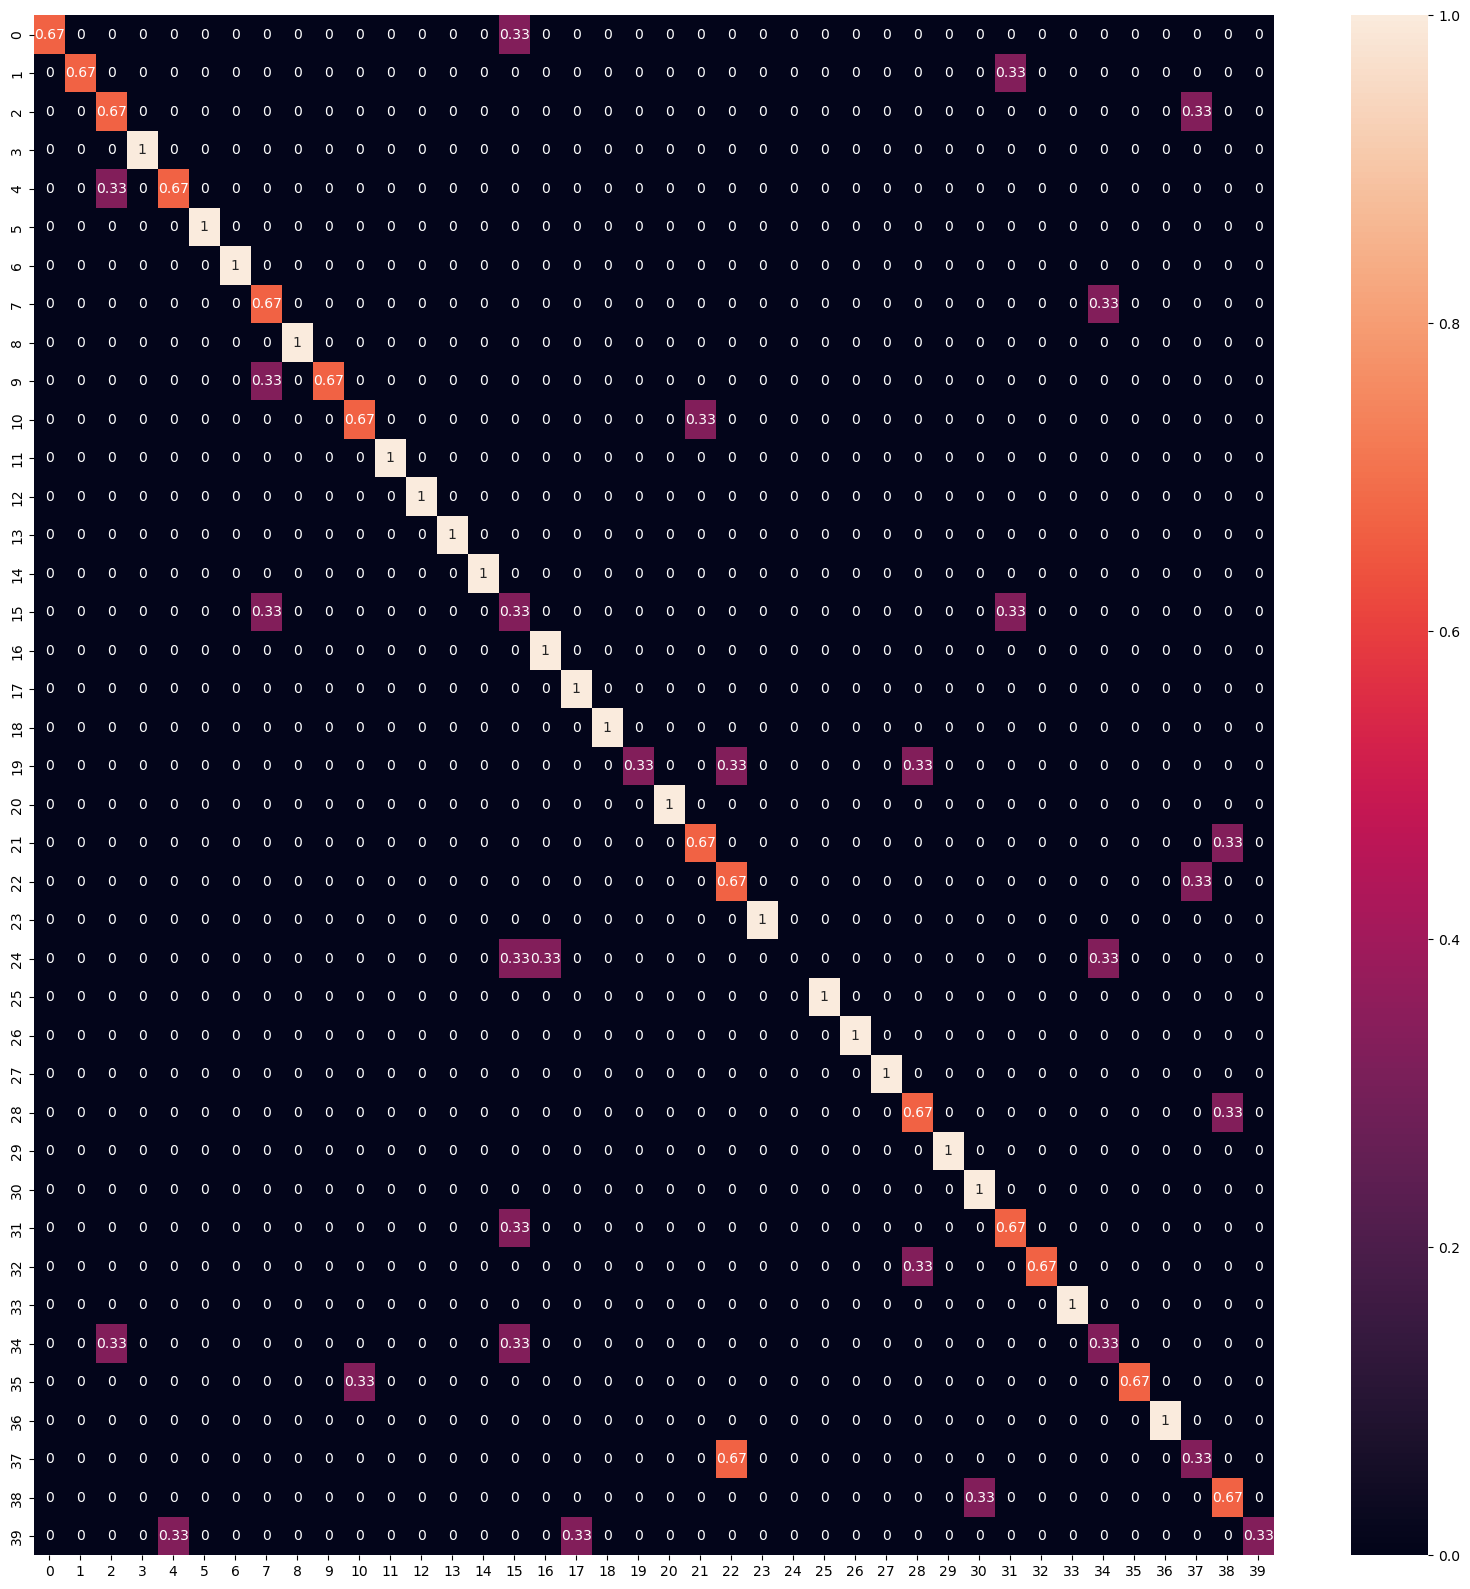

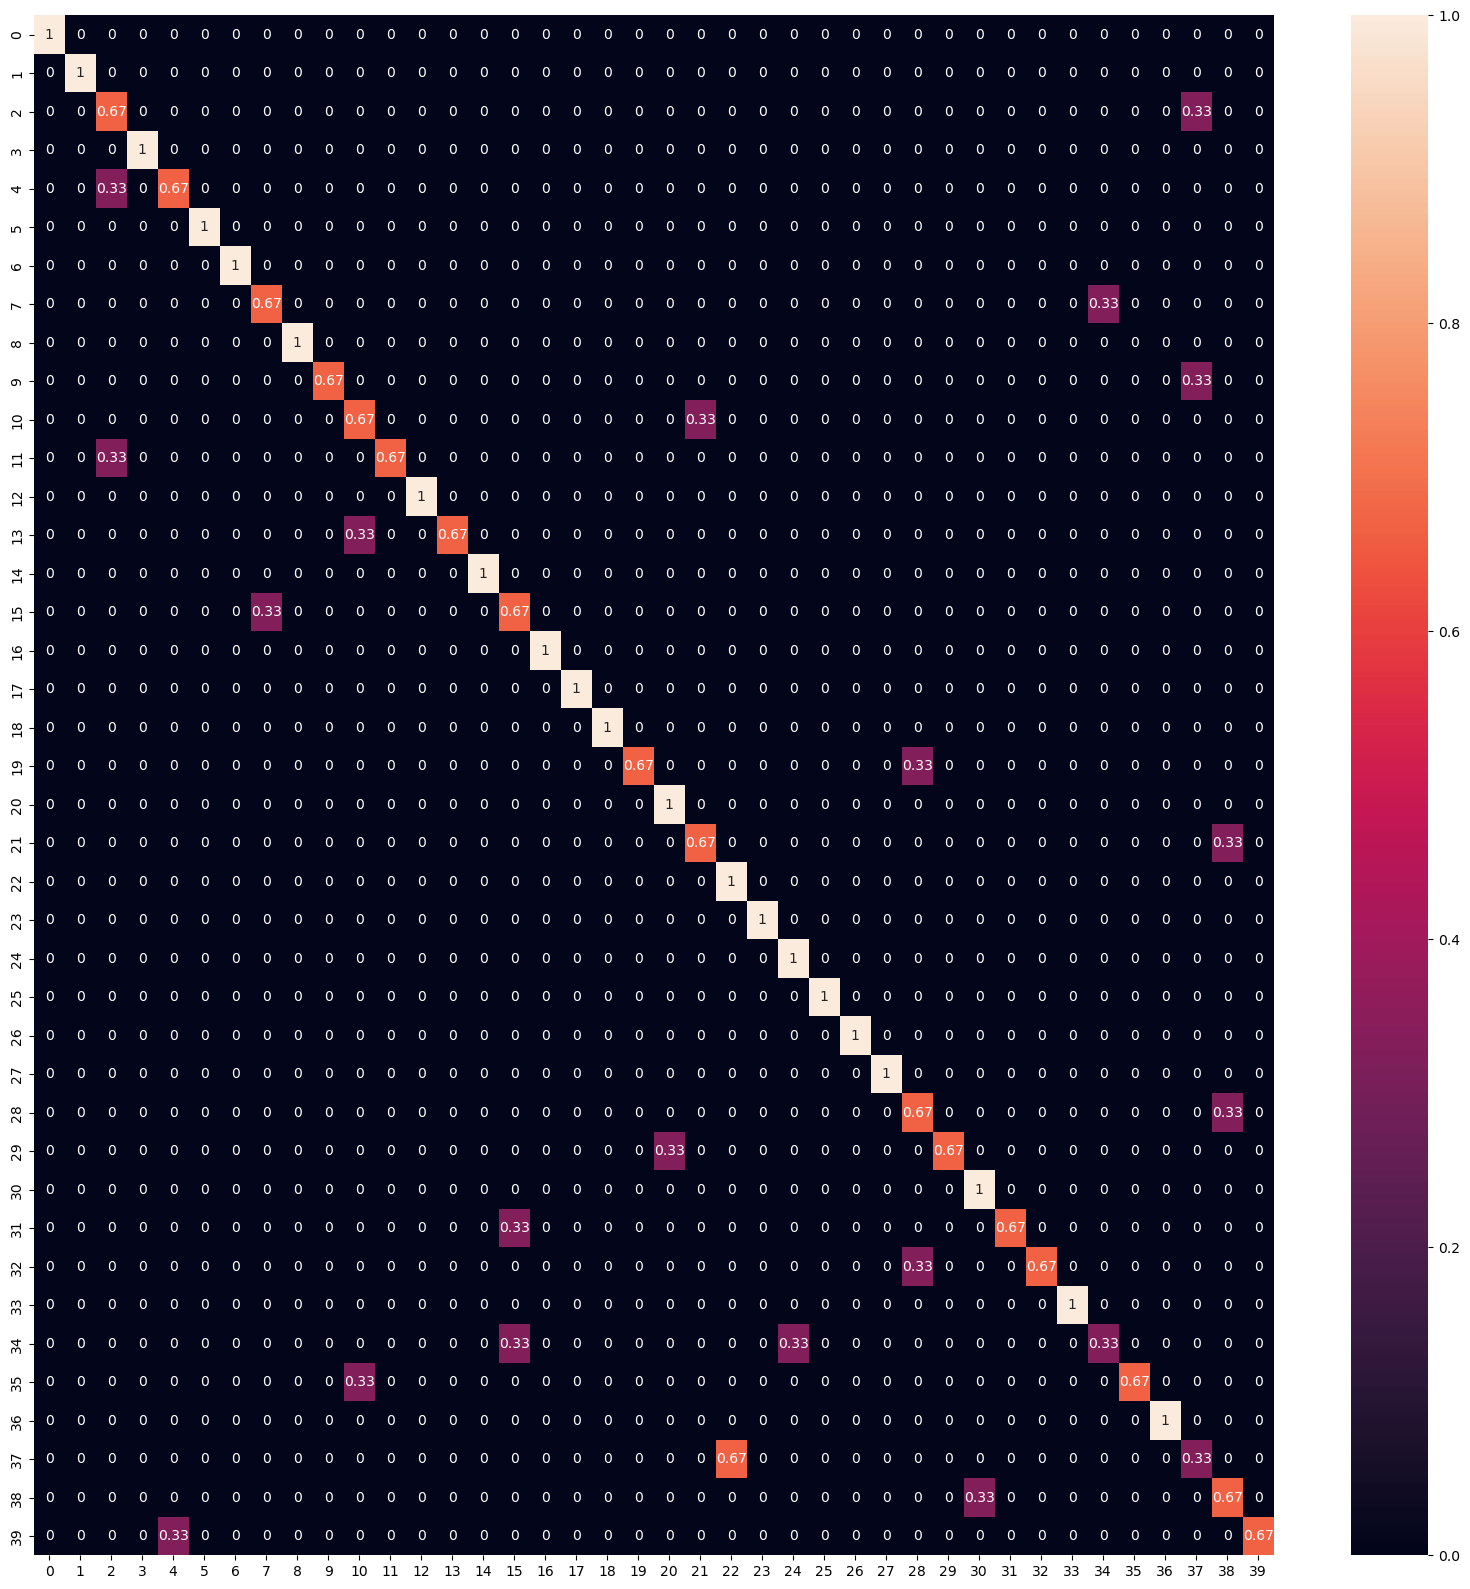

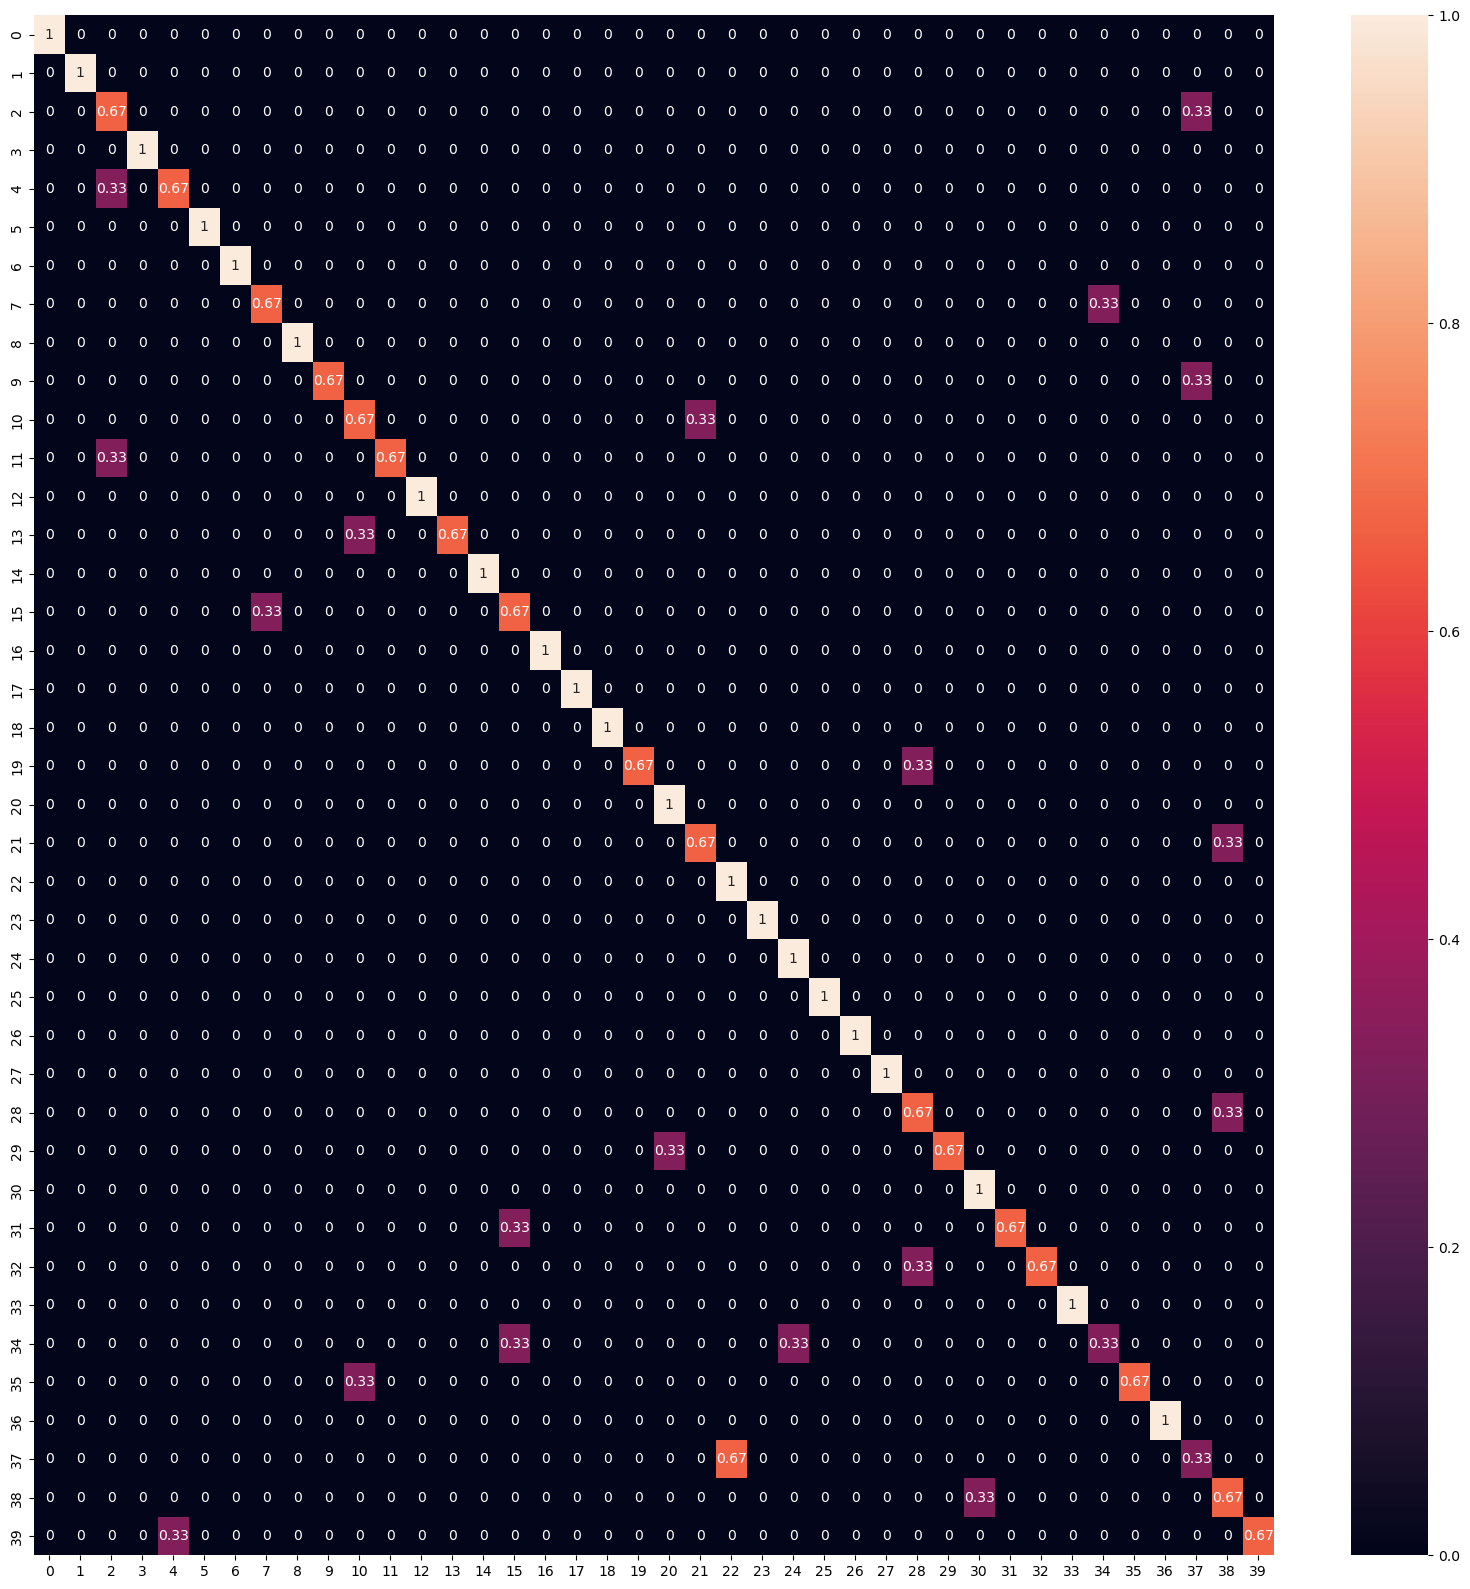

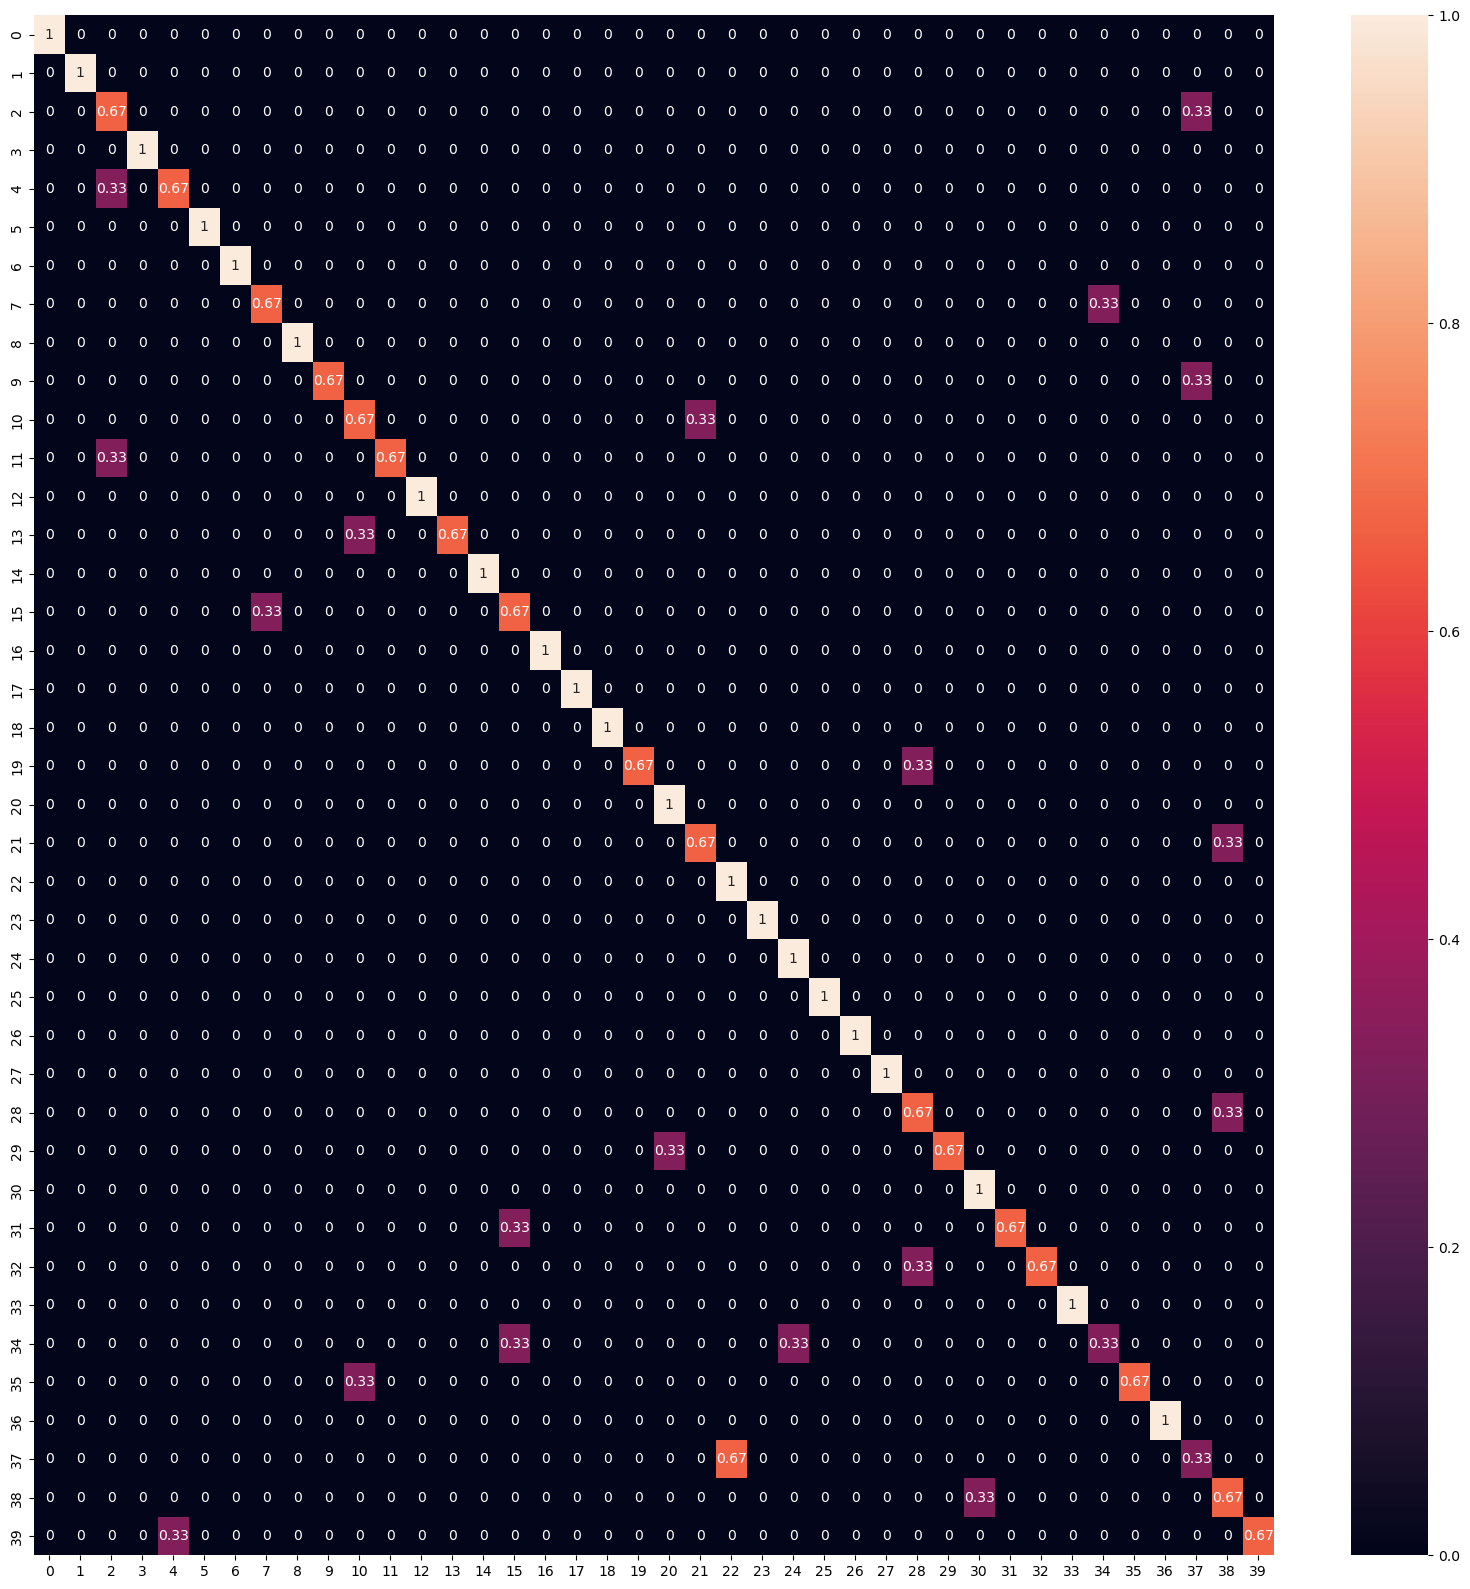

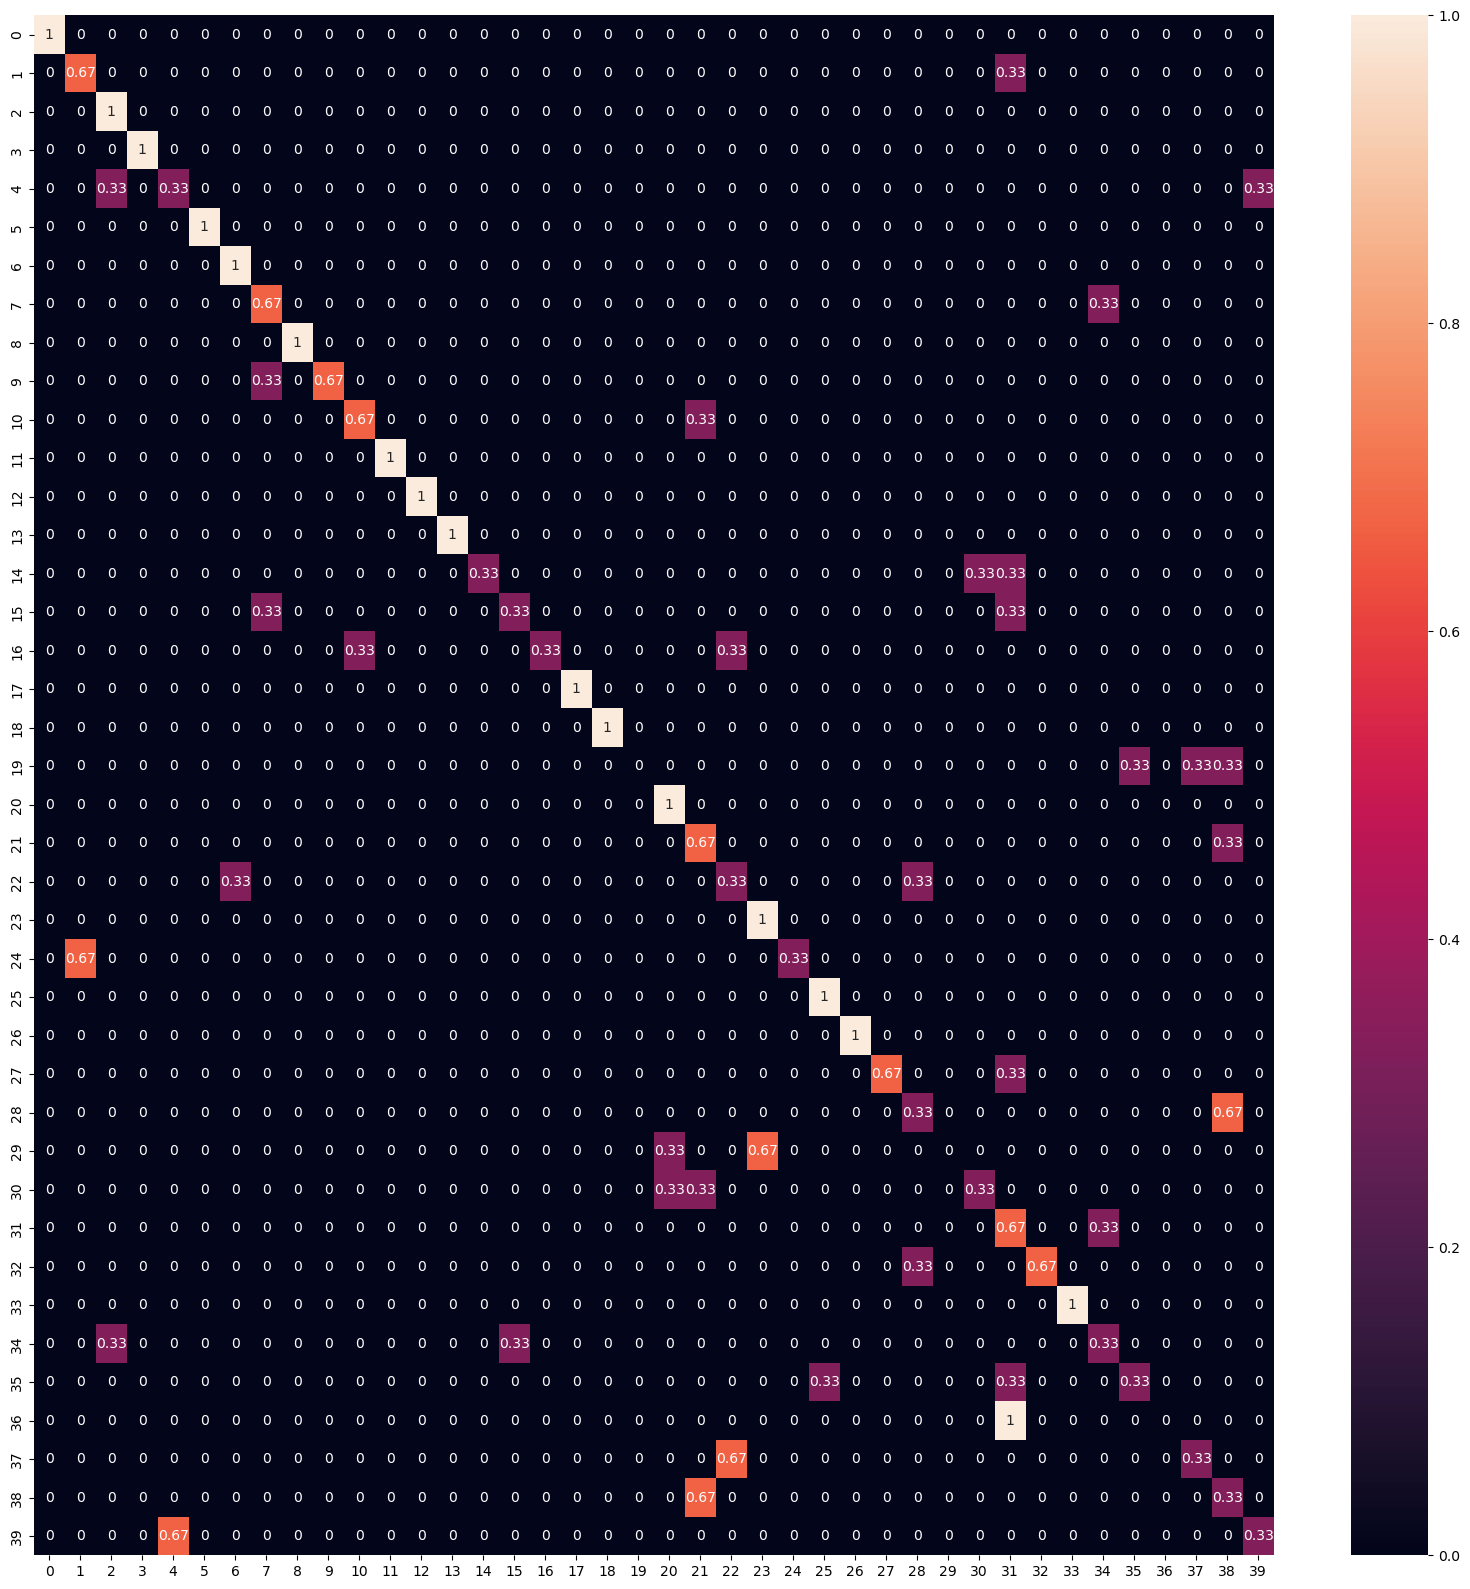

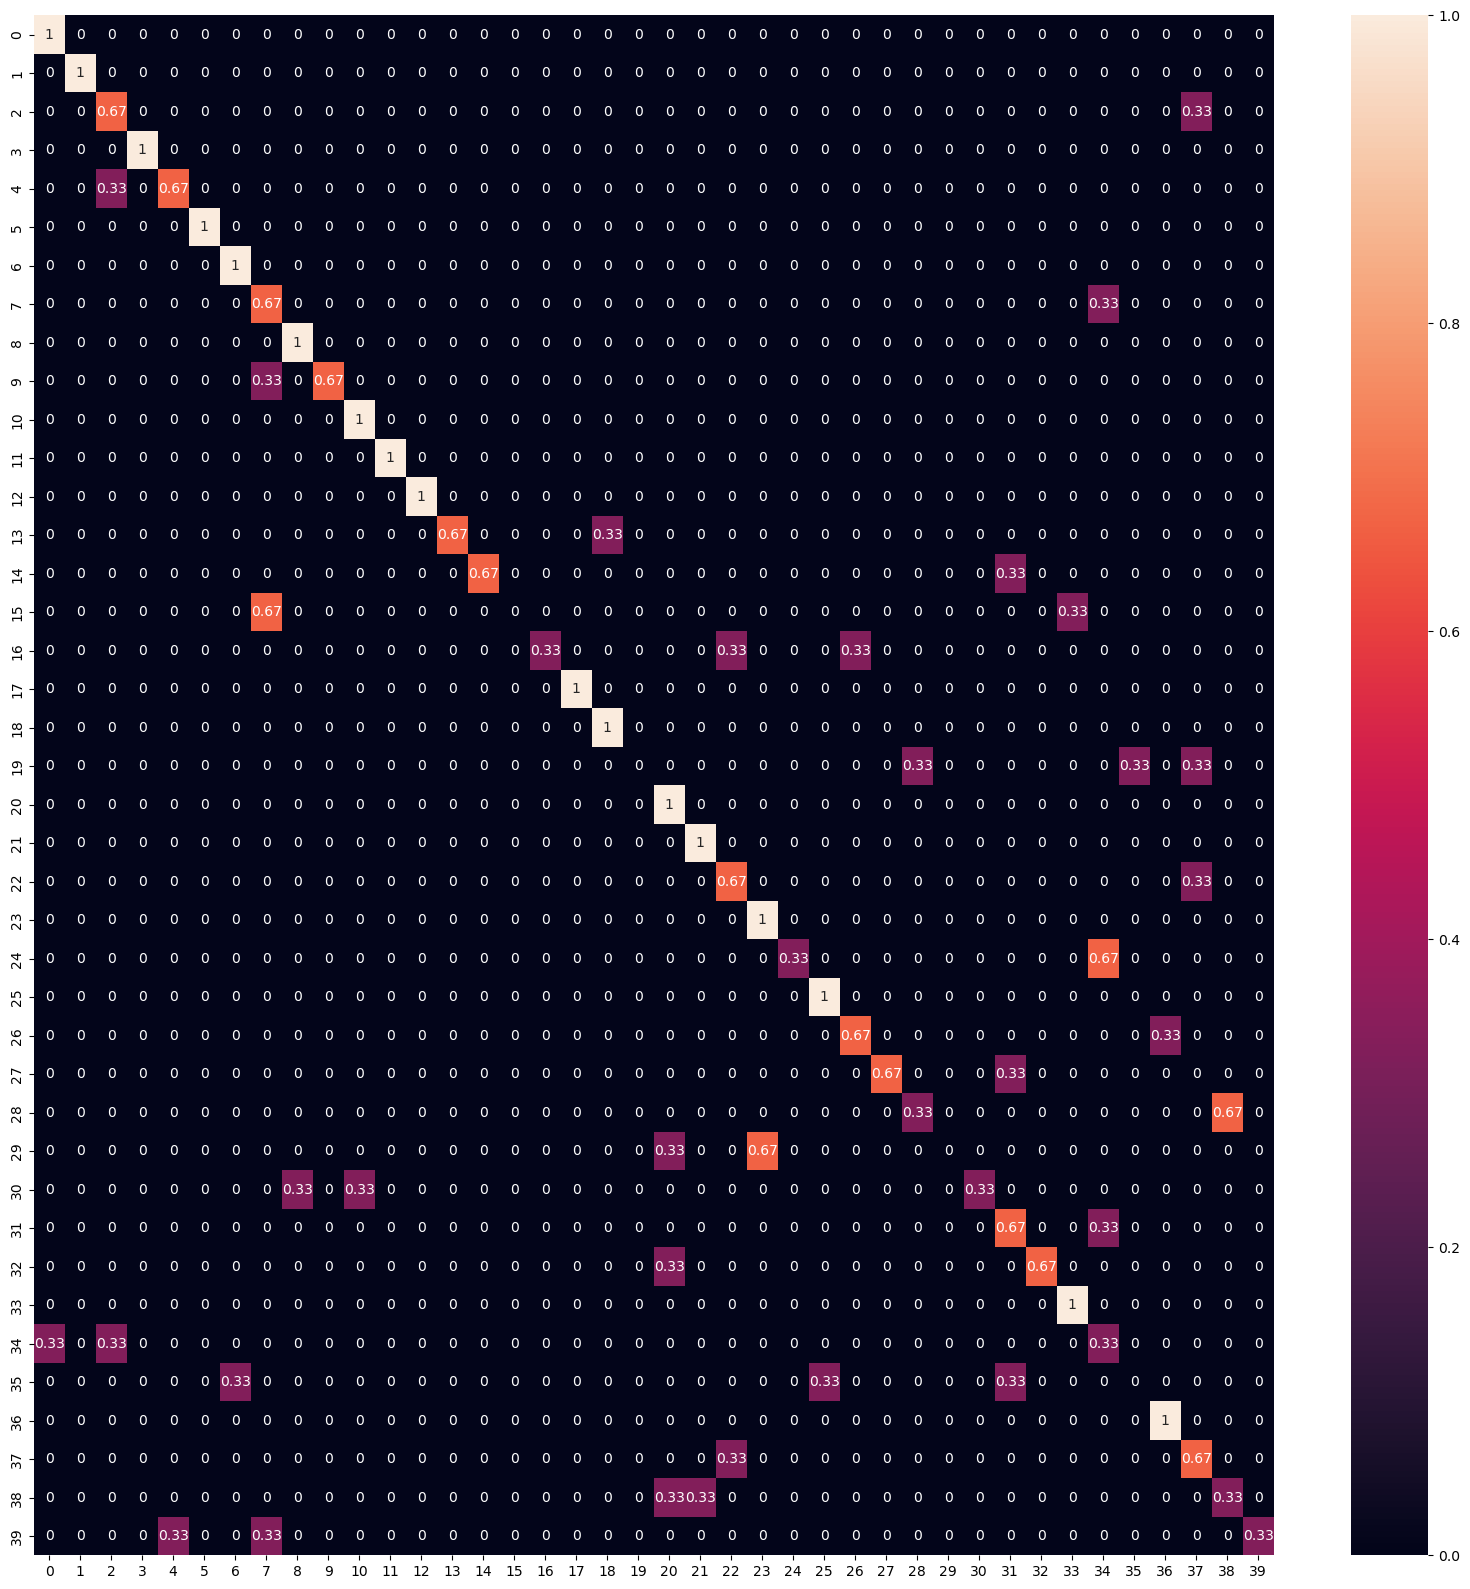

In [150]:
generate_confusion_matrix(prediction_svm_1)
generate_confusion_matrix(prediction_svm_2)
generate_confusion_matrix(prediction_svm_3)
generate_confusion_matrix(prediction_svm_4)
generate_confusion_matrix(prediction_svm_5)
generate_confusion_matrix(prediction_svm_6)
generate_confusion_matrix(prediction_svm_7)
generate_confusion_matrix(prediction_svm_8)
generate_confusion_matrix(prediction_svm_9)

# Multi-layer perceptron classification

### MLP layers = 128,64,128, Learing_rate = 0.001, activation_function = 'relu'

In [521]:
train_data, train_label = get_data(train_path)
test_data, test_label = get_data(test_path)

mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 128), learning_rate_init=0.001, random_state= 1, max_iter = 200, activation='relu')

mlp.fit(train_data, train_label)

probability_matrix_mlp_1 = mlp.predict_proba(test_data)

prediction_mlp_1 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_1 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))


MLP accuracy: 68.33%


c:\Users\alime\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP layers = 128,64,128, Learing_rate = 0.001, activation_function = 'logistic'

In [156]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 128), learning_rate_init=0.001, random_state= 1, max_iter = 200, activation='logistic')

mlp.fit(train_data, train_label)

probability_matrix_mlp_2 = mlp.predict_proba(test_data)

prediction_mlp_2 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_2 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 20.00%


c:\Users\alime\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP layers = 128,64,128, Learing_rate = 0.001, activation_function = 'identity'

In [157]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 128), learning_rate_init=0.001, random_state= 1, max_iter = 200, activation='identity')

mlp.fit(train_data, train_label)

probability_matrix_mlp_3 = mlp.predict_proba(test_data)

prediction_mlp_3 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_3 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 7.50%


### MLP layers = 128,64,128, Learing_rate = 0.001, activation_function = 'tanh'

In [158]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 128), learning_rate_init=0.001, random_state= 1, max_iter = 200, activation='tanh')

mlp.fit(train_data, train_label)

probability_matrix_mlp_4 = mlp.predict_proba(test_data)

prediction_mlp_4 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_4 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 41.67%


### MLP layers = 128,64,128, Learing_rate = 0.0001, activation_function = 'relu'

In [167]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 128), learning_rate_init=0.0001, random_state= 1, max_iter = 200, activation='relu')

mlp.fit(train_data, train_label)

probability_matrix_mlp_5 = mlp.predict_proba(test_data)

prediction_mlp_5 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_5 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 60.00%


c:\Users\alime\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP layers = 128,64,128, Learing_rate = 0.01, activation_function = 'relu'

In [171]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 128), learning_rate_init=0.01, random_state= 1, max_iter = 200, activation='relu')

mlp.fit(train_data, train_label)

probability_matrix_mlp_6 = mlp.predict_proba(test_data)

prediction_mlp_6 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_6 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 45.83%


### MLP layers = 256,128,256, Learing_rate = 0.001, activation_function = 'relu'

In [172]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 256), learning_rate_init=0.001, random_state= 1, max_iter = 200, activation='relu')

mlp.fit(train_data, train_label)

probability_matrix_mlp_7 = mlp.predict_proba(test_data)

prediction_mlp_7 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_7 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 68.33%


c:\Users\alime\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP layers = 512,256,512, Learing_rate = 0.001, activation_function = 'relu'

In [173]:
mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 512), learning_rate_init=0.001, random_state= 1, max_iter = 200, activation='relu')

mlp.fit(train_data, train_label)

probability_matrix_mlp_8 = mlp.predict_proba(test_data)

prediction_mlp_8 = mlp.predict(test_data)
accuracy = np.mean(prediction_mlp_8 == test_label)
print('MLP accuracy: {:.2f}%'.format(accuracy * 100))

MLP accuracy: 72.50%


c:\Users\alime\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## ROC and DET curves for MLP

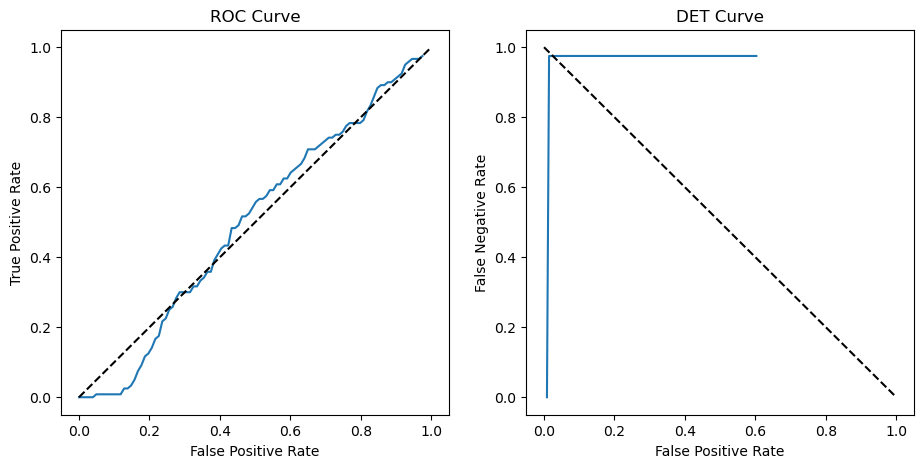

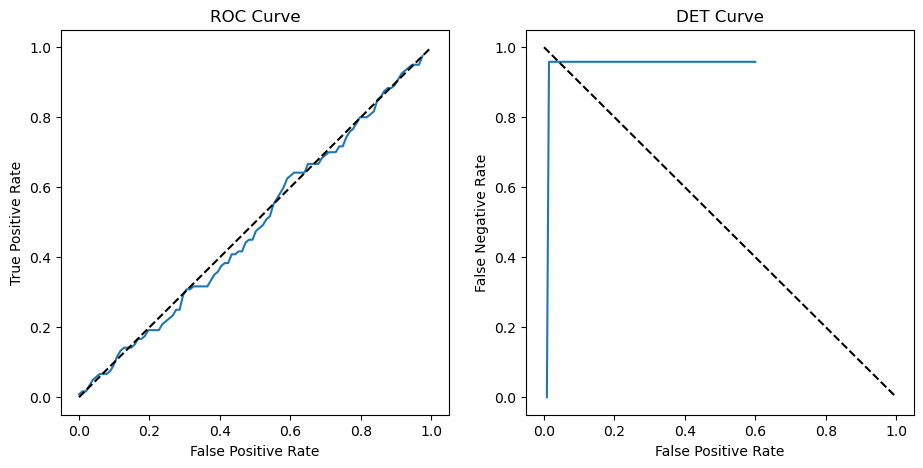

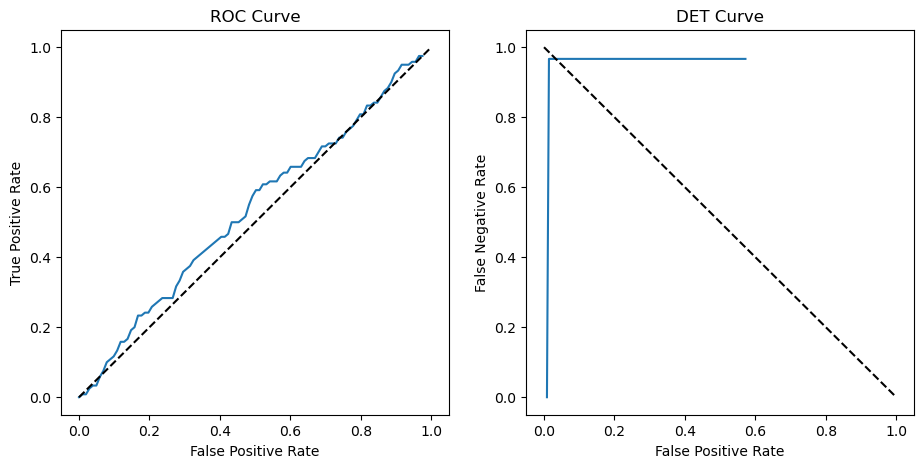

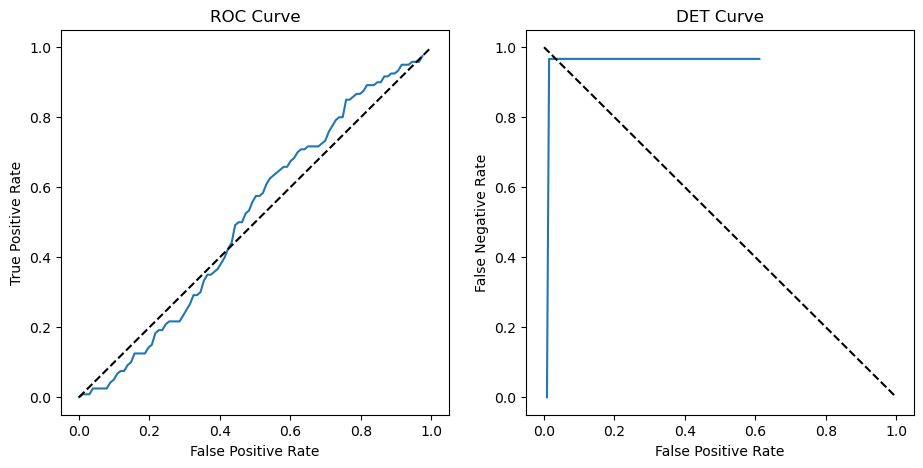

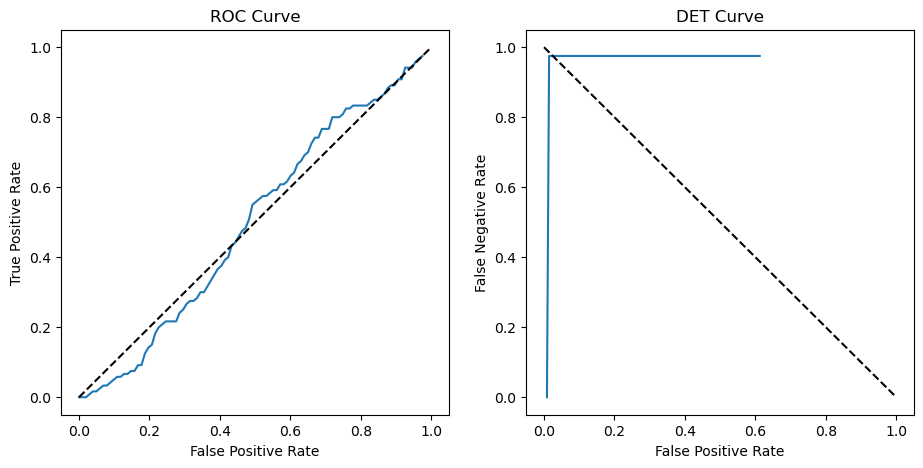

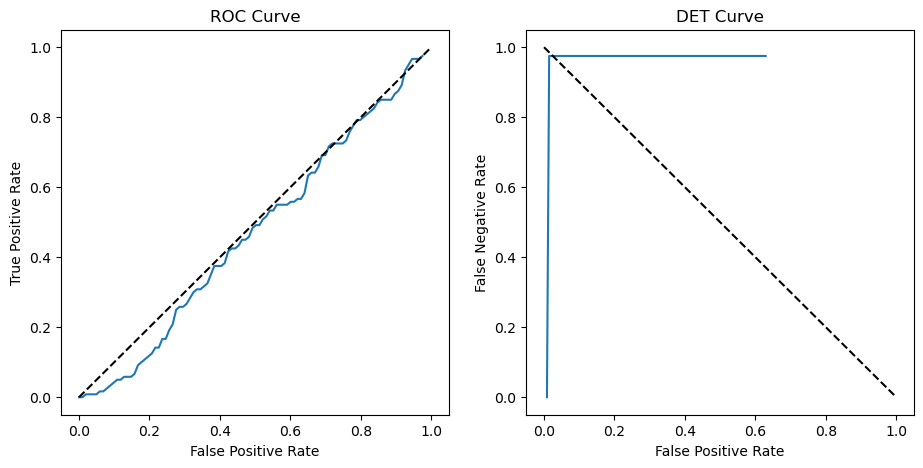

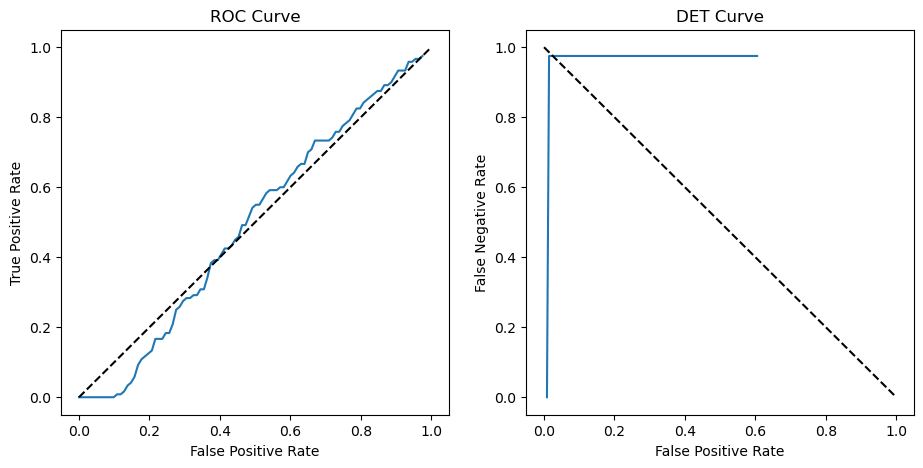

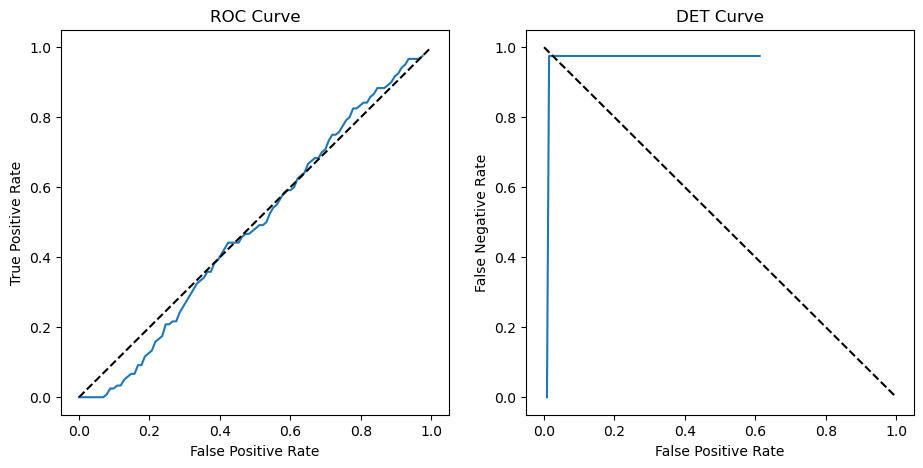

In [174]:
generate_roc_det_curve(probability_matrix_mlp_1)
generate_roc_det_curve(probability_matrix_mlp_2)
generate_roc_det_curve(probability_matrix_mlp_3)
generate_roc_det_curve(probability_matrix_mlp_4)
generate_roc_det_curve(probability_matrix_mlp_5)
generate_roc_det_curve(probability_matrix_mlp_6)
generate_roc_det_curve(probability_matrix_mlp_7)
generate_roc_det_curve(probability_matrix_mlp_8)

## Confusion Matrix for MLP

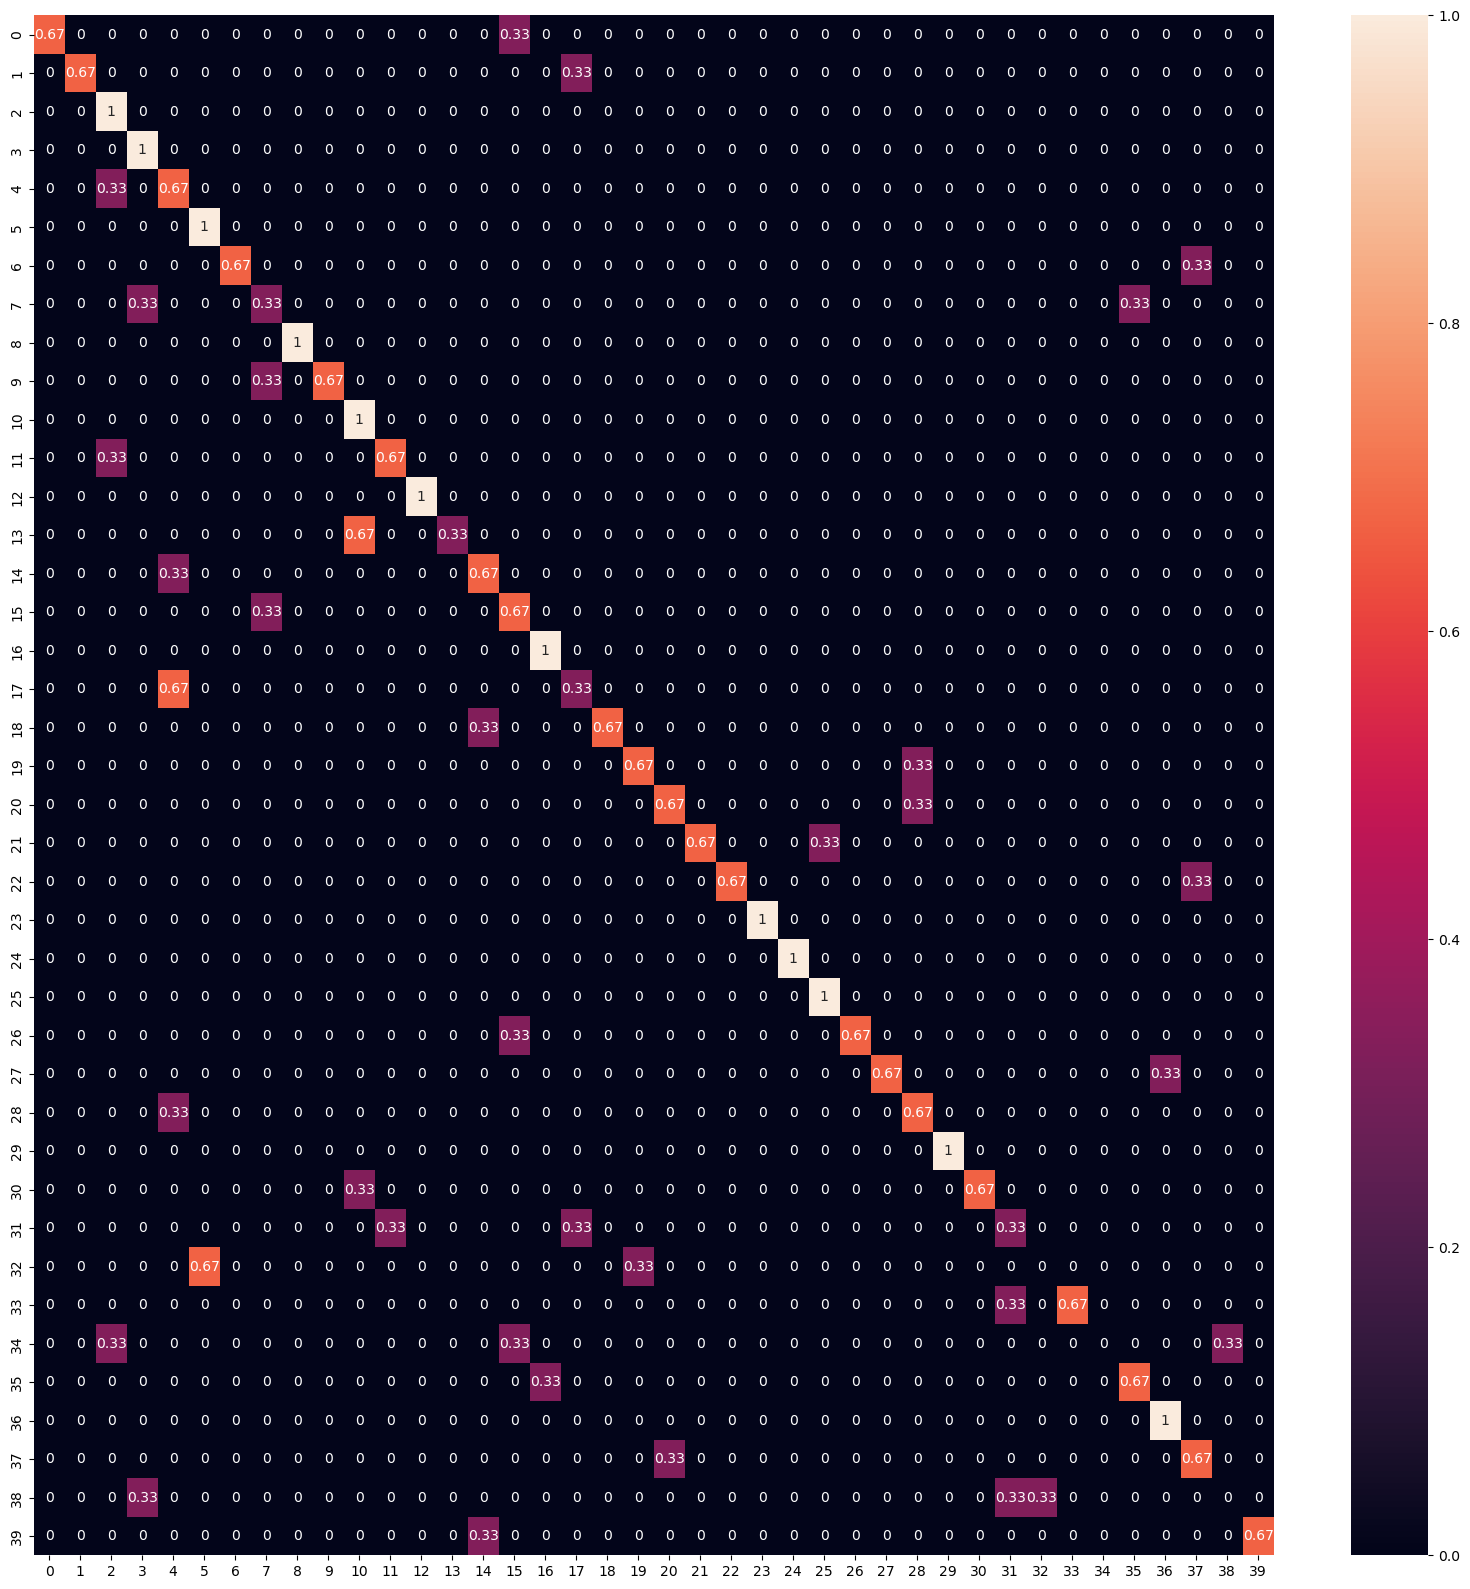

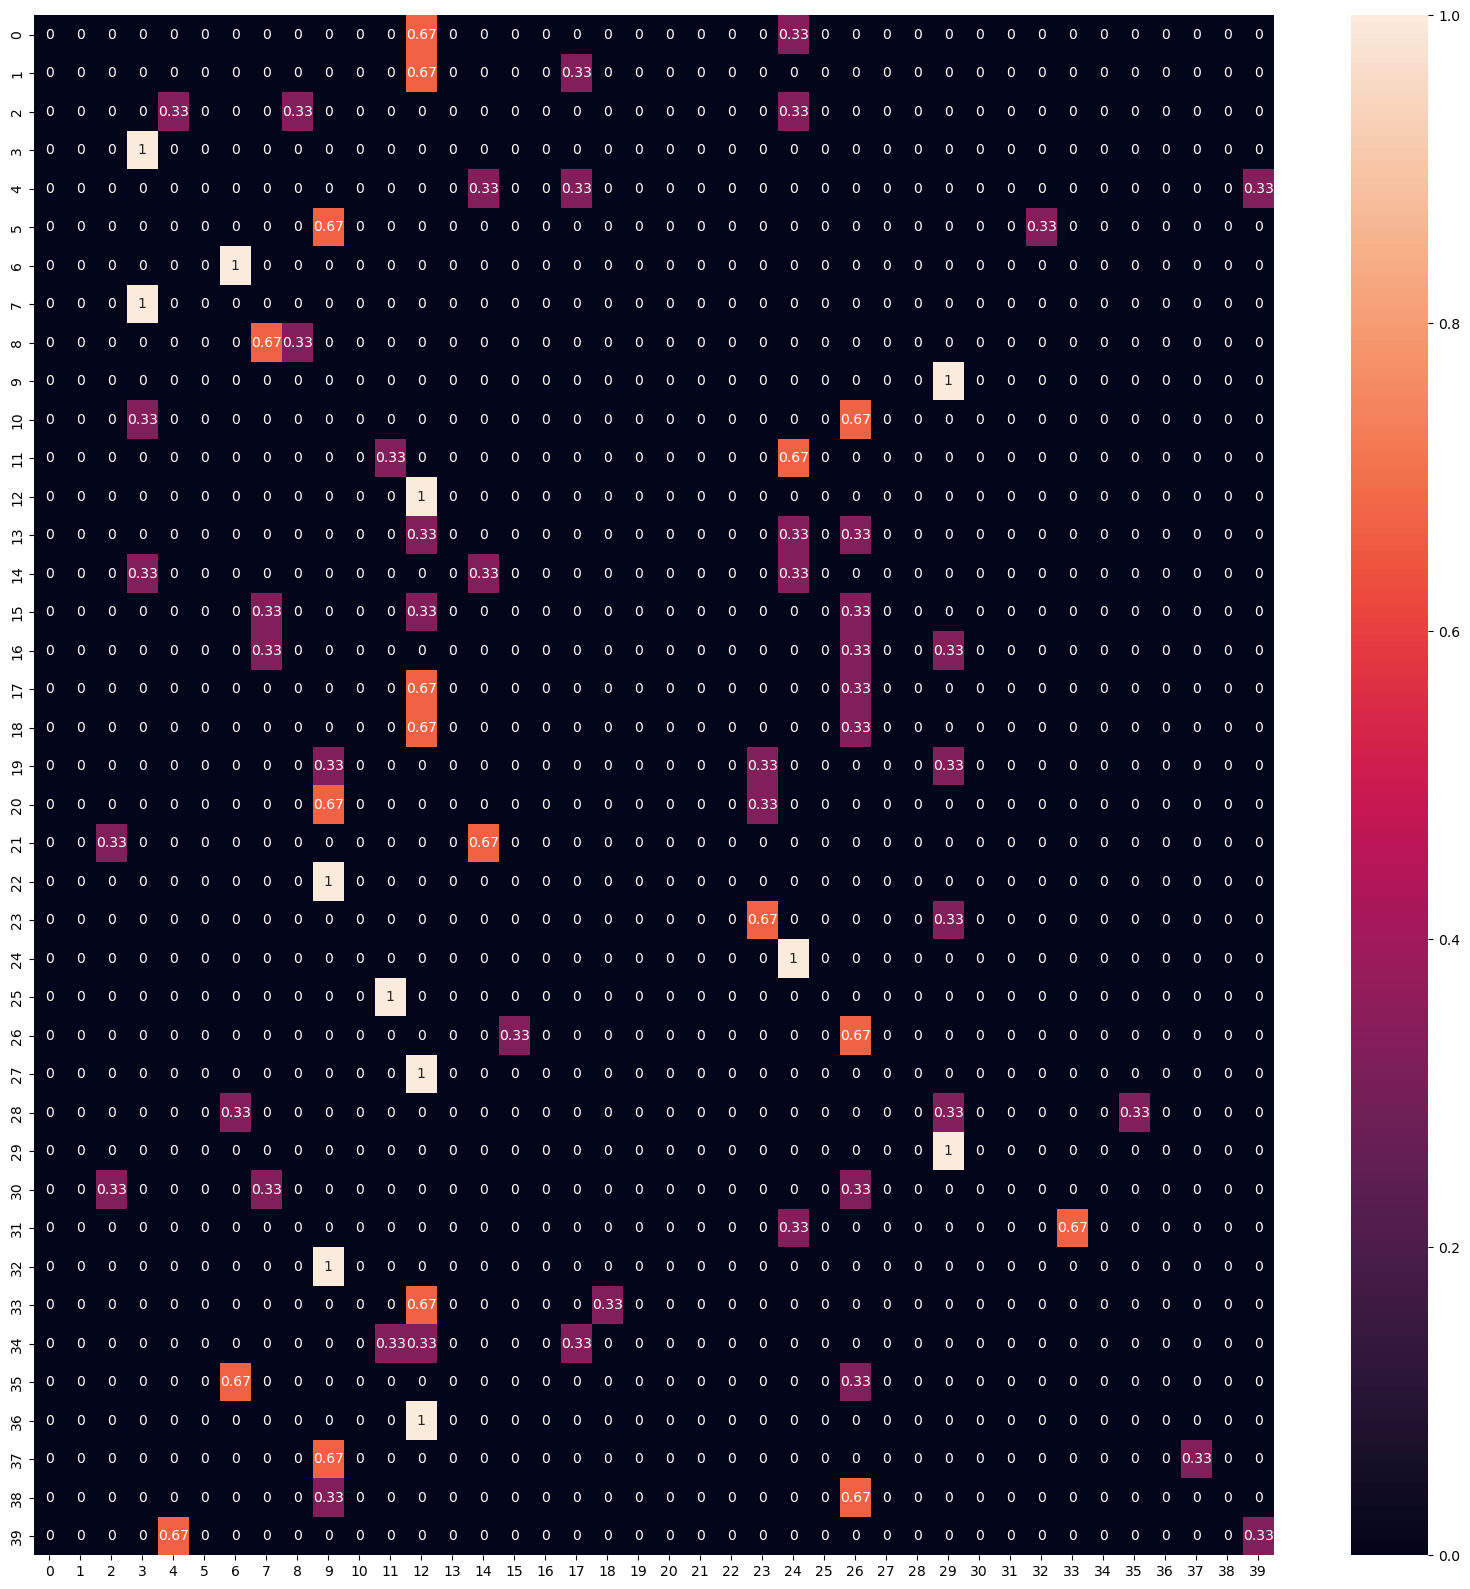

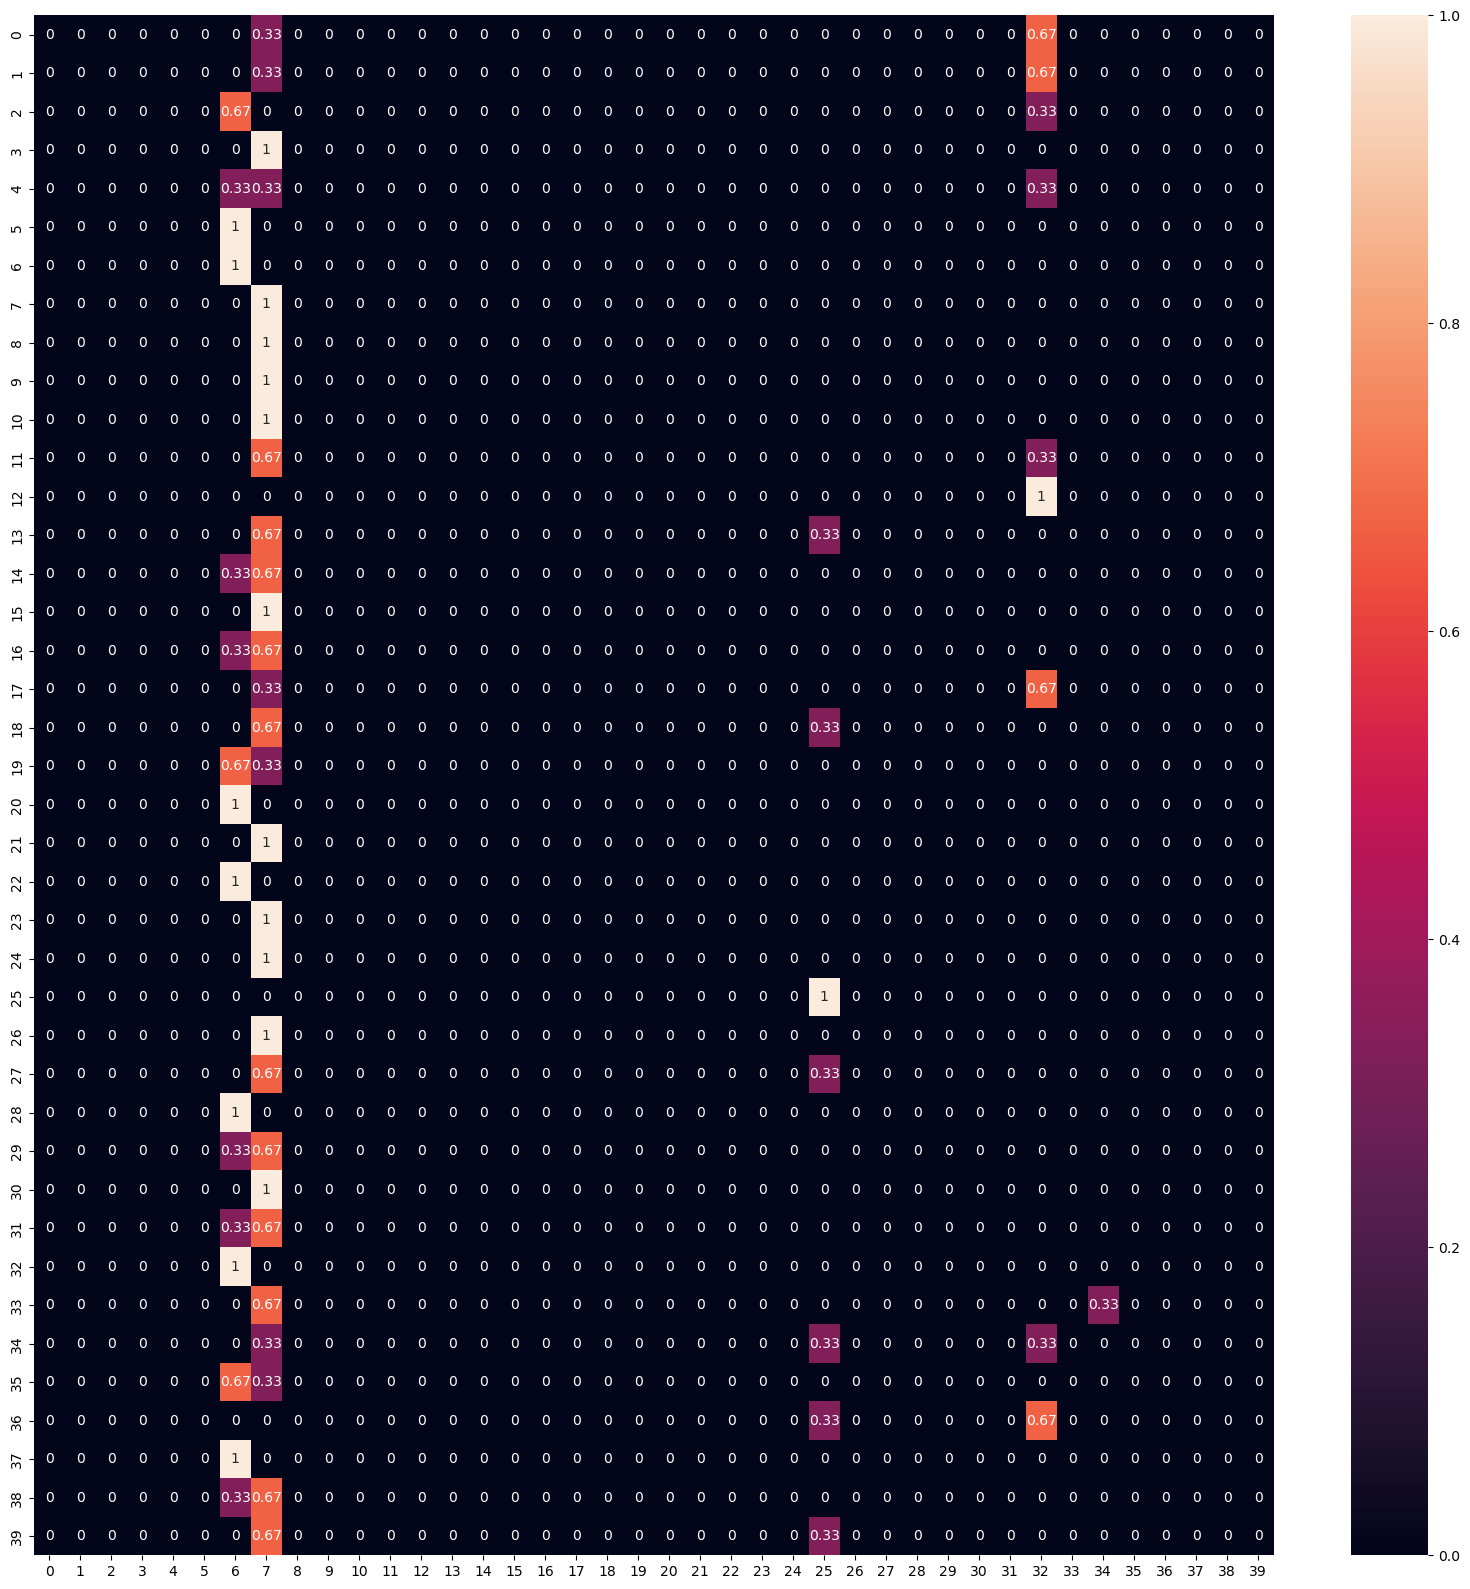

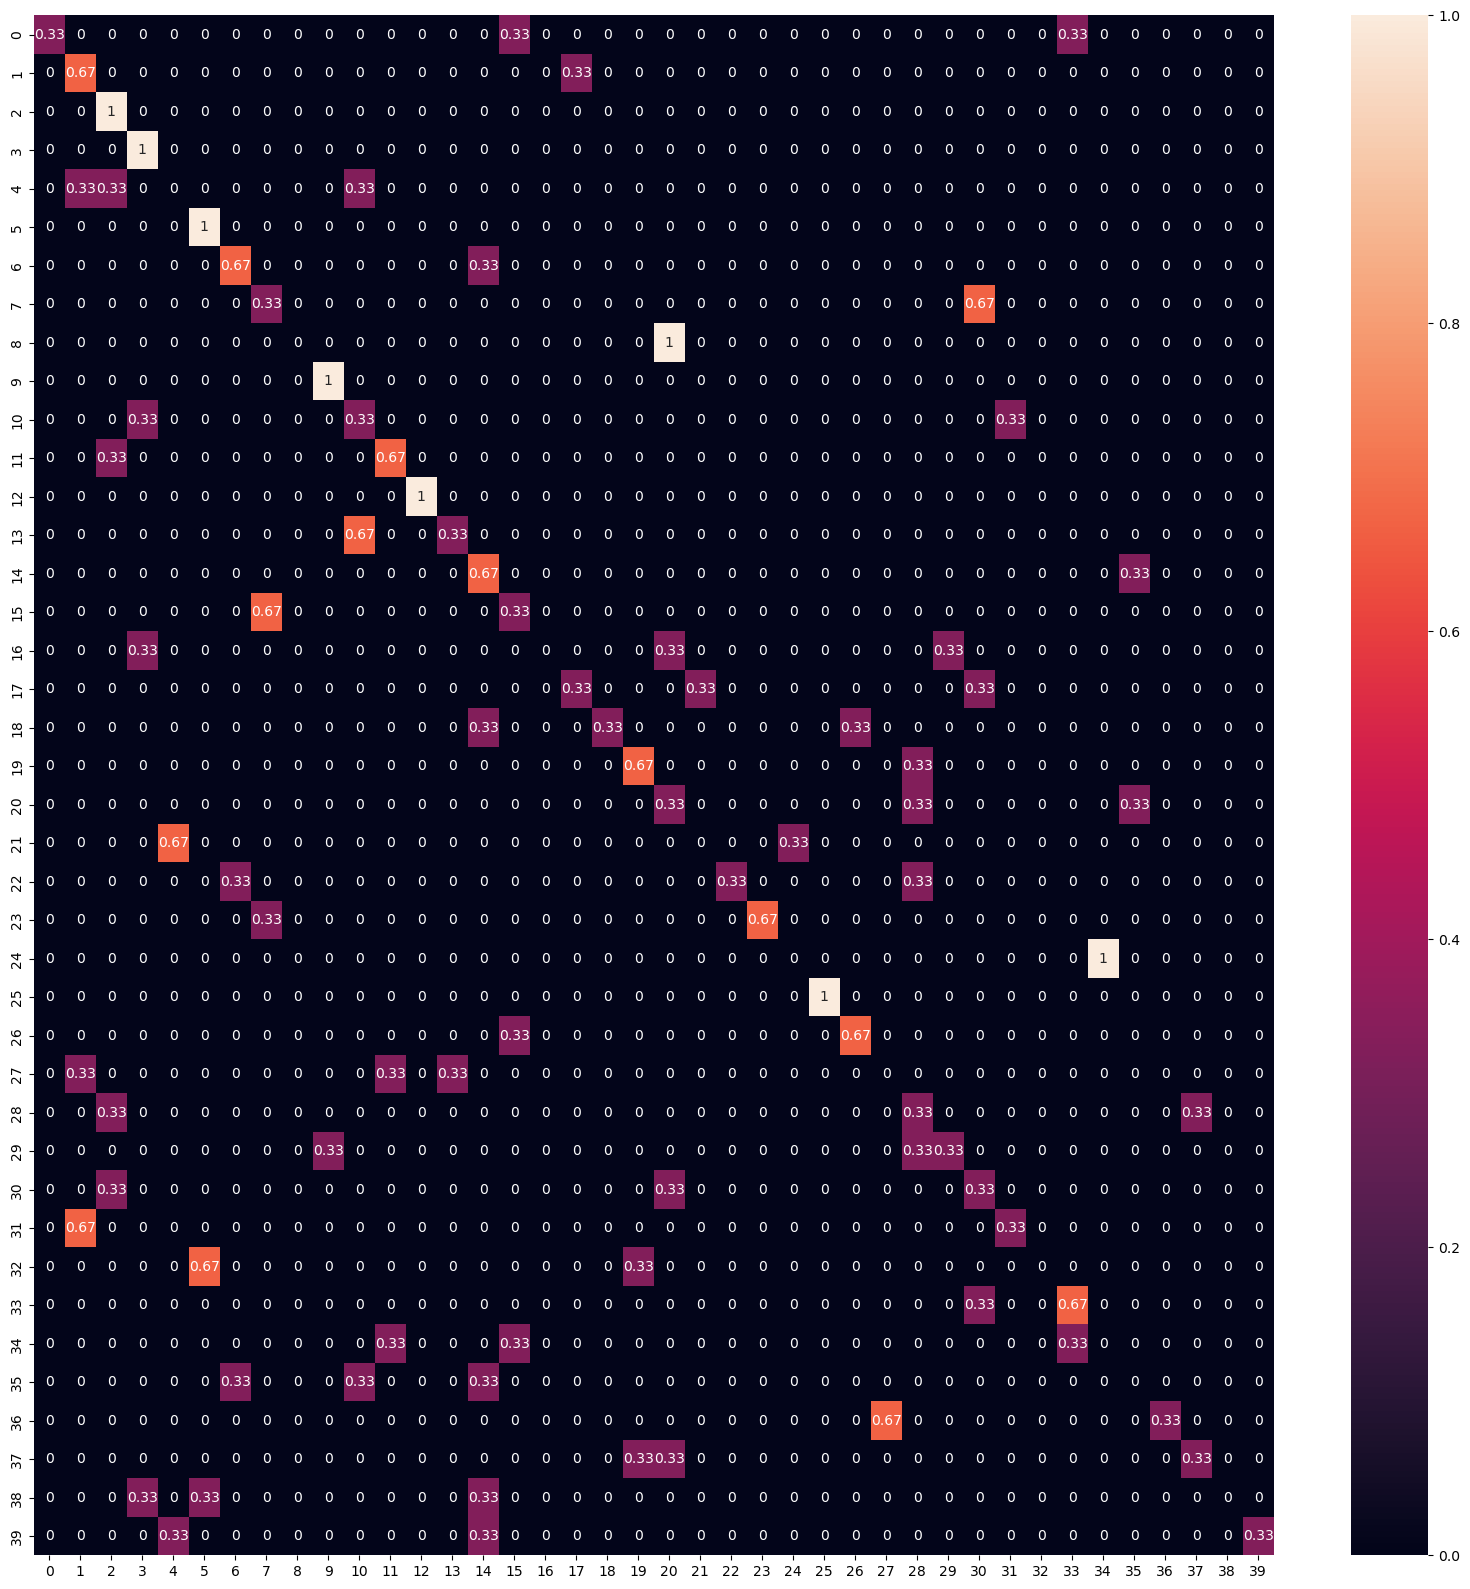

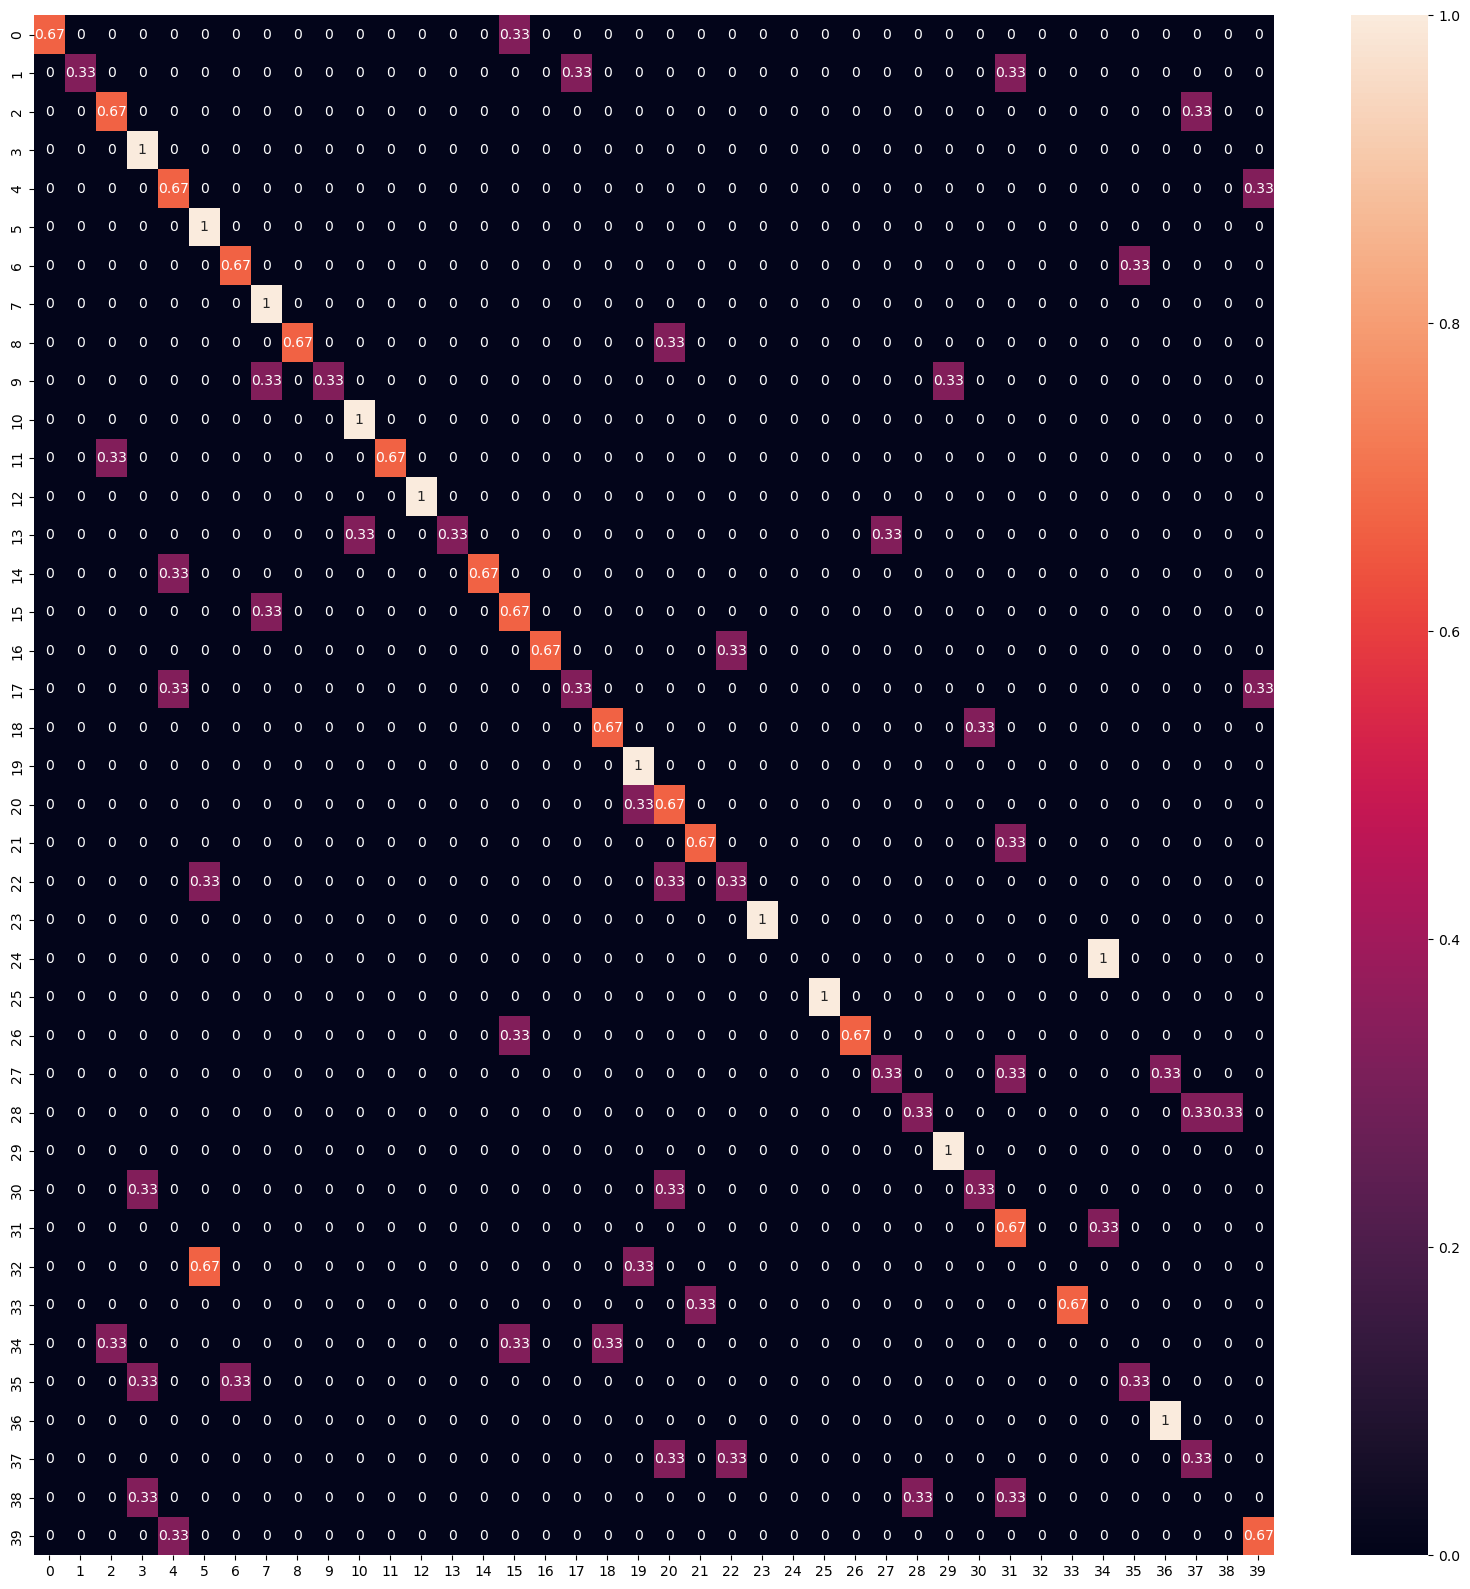

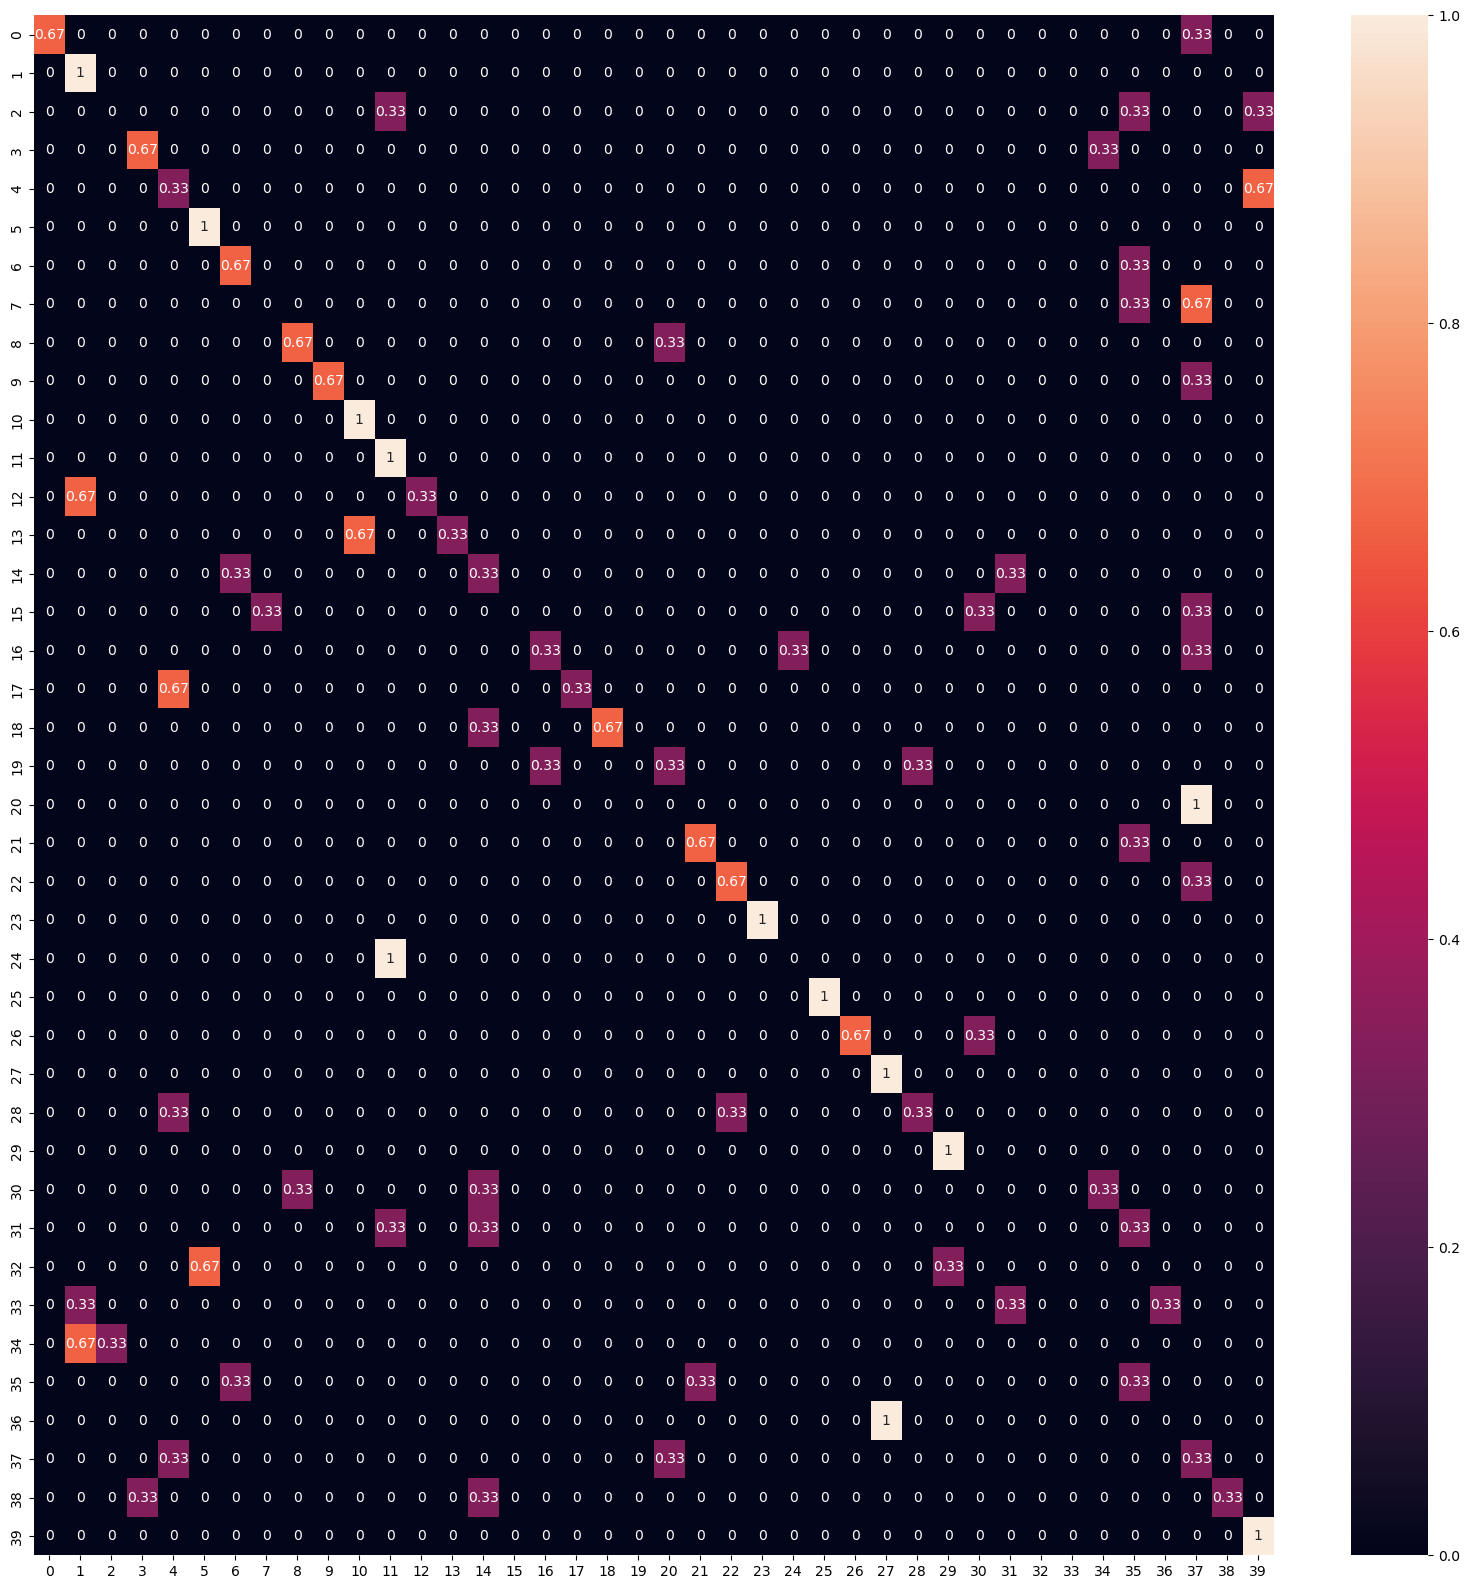

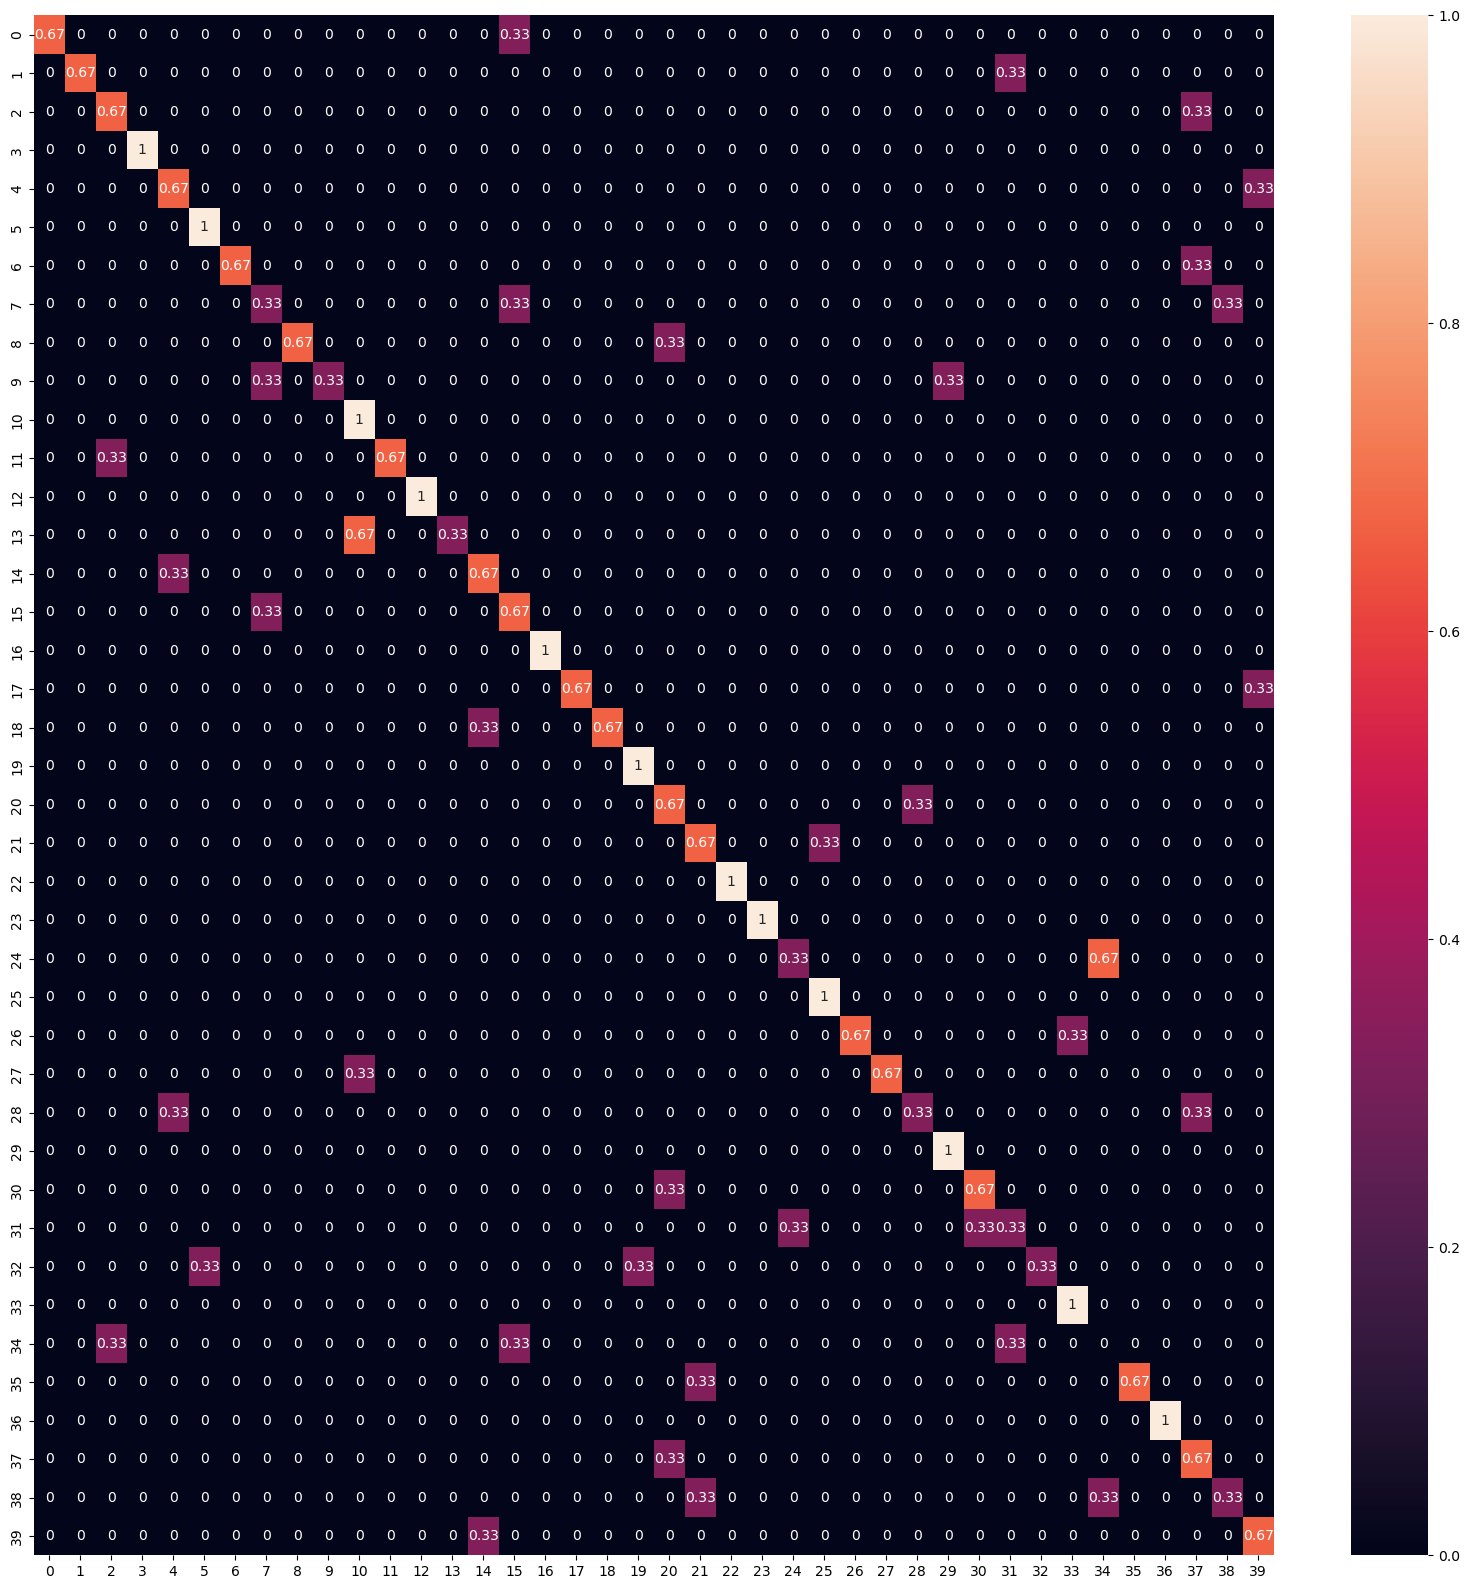

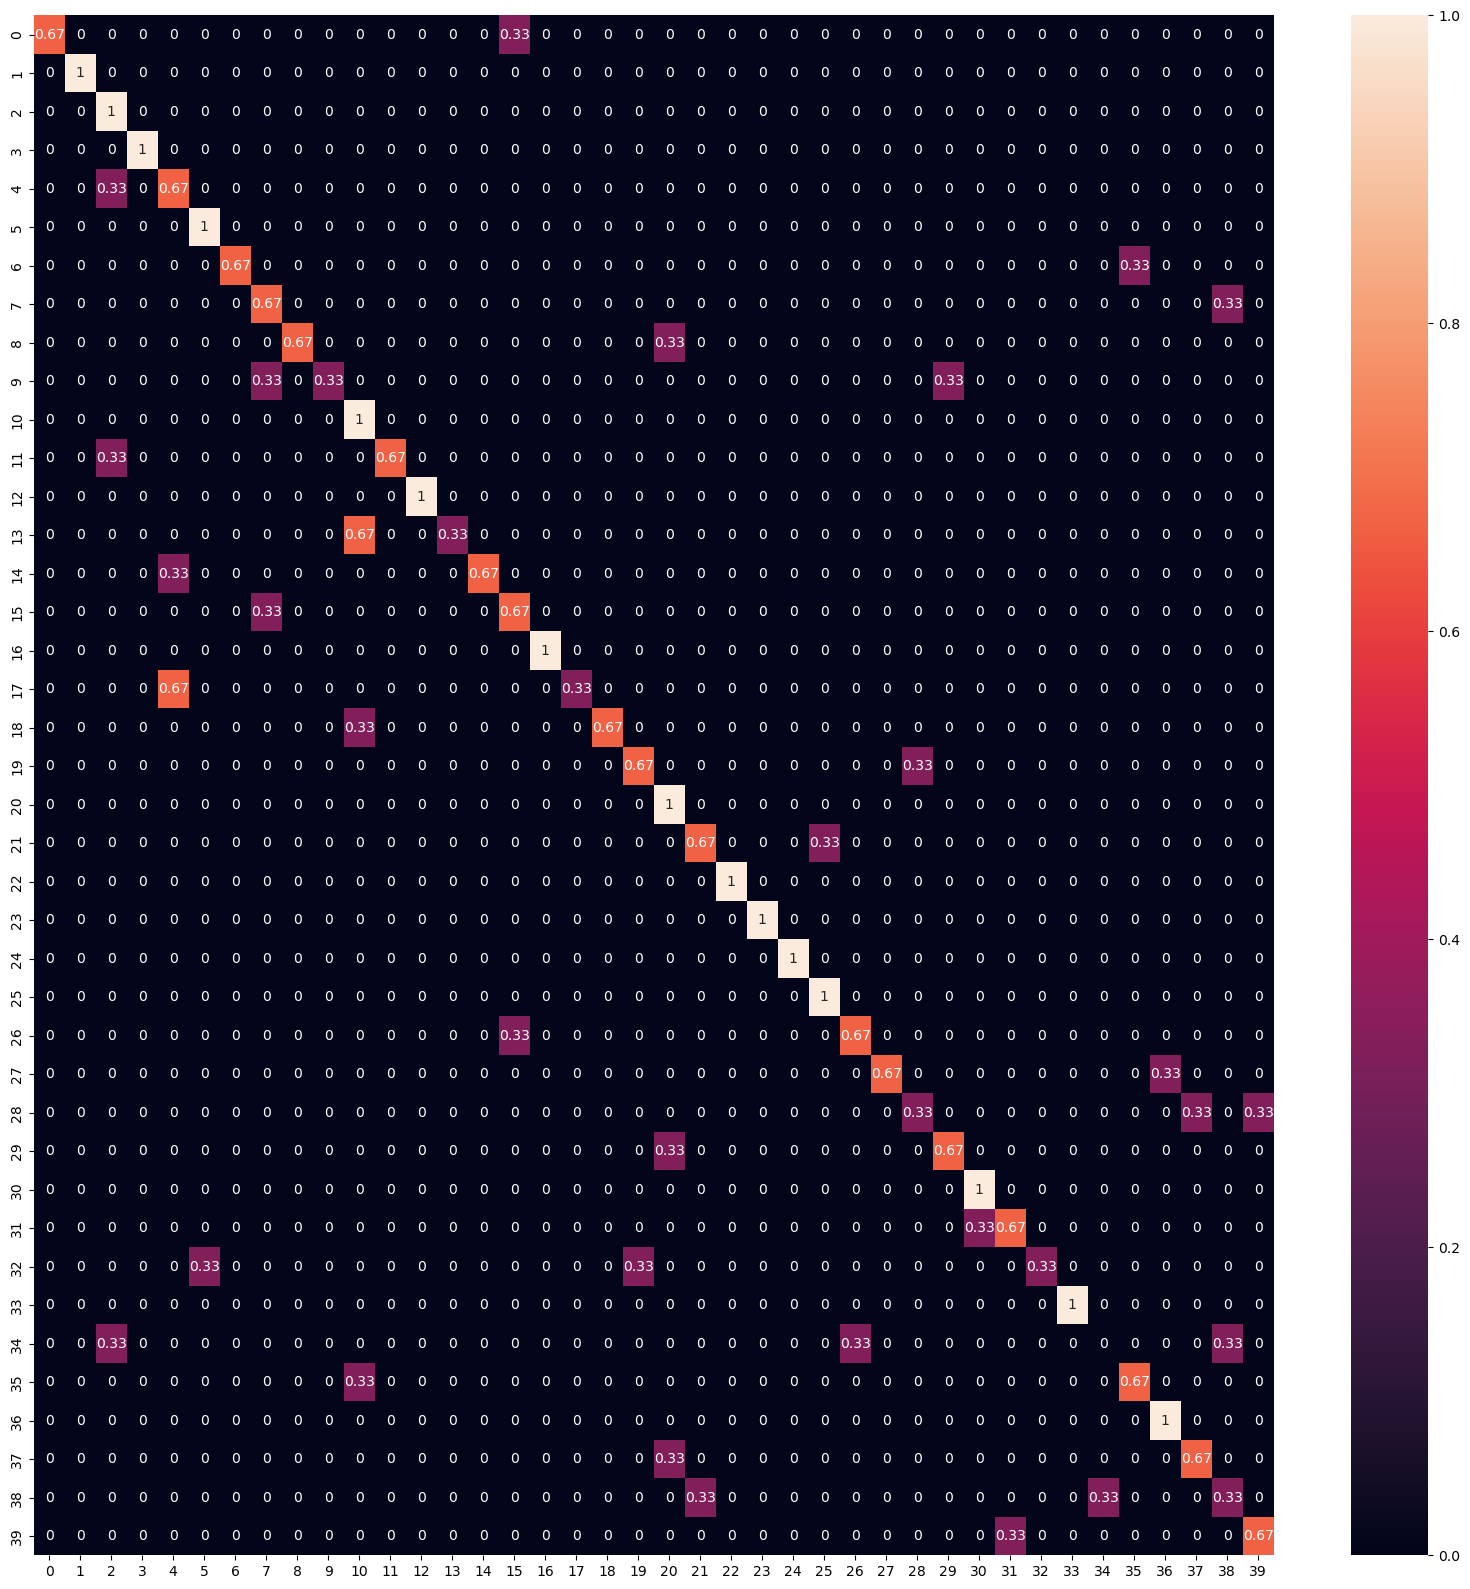

In [175]:
generate_confusion_matrix(prediction_mlp_1)
generate_confusion_matrix(prediction_mlp_2)
generate_confusion_matrix(prediction_mlp_3)
generate_confusion_matrix(prediction_mlp_4)
generate_confusion_matrix(prediction_mlp_5)
generate_confusion_matrix(prediction_mlp_6)
generate_confusion_matrix(prediction_mlp_7)
generate_confusion_matrix(prediction_mlp_8)
